In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from utils import *
import warnings
from sklearn.preprocessing import MinMaxScaler
import re
import datetime
from darts_helper.preprocess import get_covariates, get_target_series
from darts_helper.trainer import Trainer

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

In [154]:
# Import
df_train = pd.read_csv('originalni_datasetovi/train.csv')

date_min_train = df_train.date.min()
date_max_train = df_train.date.max()
NO_FAMILIES = df_train.family.nunique()
NO_STORES = df_train.store_nbr.nunique()


df_test = pd.read_csv('originalni_datasetovi/test.csv')
df_stores = pd.read_csv('originalni_datasetovi/stores.csv')
df_oil = pd.read_csv('originalni_datasetovi/oil.csv')
df_holidays = pd.read_csv('originalni_datasetovi/holidays_events.csv')
df_transactions = pd.read_csv('originalni_datasetovi/transactions.csv', parse_dates=['date']).sort_values(['store_nbr', 'date'])

# Visualization

## Oil
Oil data contains only two attributes: **Date** and **dcoilwtico**(oil price for a given day).

In [64]:
df_oil.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [65]:
df_oil.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True) # change column name for readability
df_oil['date'] = pd.to_datetime(df_oil.date)
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1218 non-null   datetime64[ns]
 1   oil_price  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


There are no data about oil prices on weekends so we use linear interpolation for those dates. \
Linear interpolation ignores the index and treat the values as equally spaced.

In [66]:
df_oil.loc[df_oil['date'] == '2013-01-01', 'oil_price'] = 93.14 # since linear interpolation doesnt work on data thats not between data points we use 2nd data point as 1st data point
df_oil = df_oil.interpolate(method='linear', limit=20)
df_oil.describe()

date    oil_price
count                 1218  1218.000000
mean   2015-05-02 12:00:00    67.682742
min    2013-01-01 00:00:00    26.190000
25%    2014-03-03 06:00:00    46.422500
50%    2015-05-02 12:00:00    53.185000
75%    2016-06-30 18:00:00    95.685000
max    2017-08-31 00:00:00   110.620000
std                    NaN    25.632933

We see 2 peaks on distribution plot, one for data before 2015 and one for data after 2015.

Text(0.5, 1.0, 'Distribution : Oil Price')

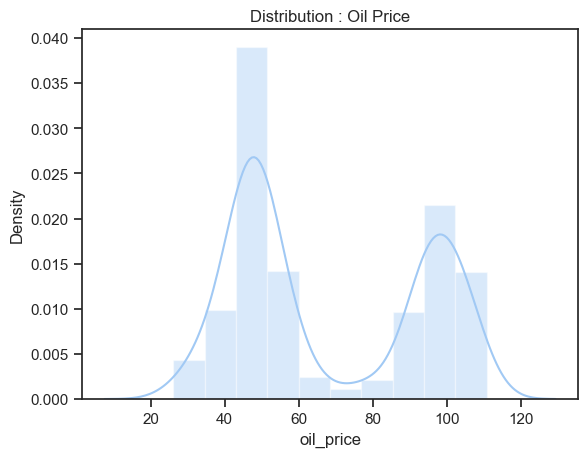

In [67]:
sns.distplot(df_oil['oil_price'])
plt.title('Distribution : Oil Price')

Text(0, 0.5, 'Oil Price')

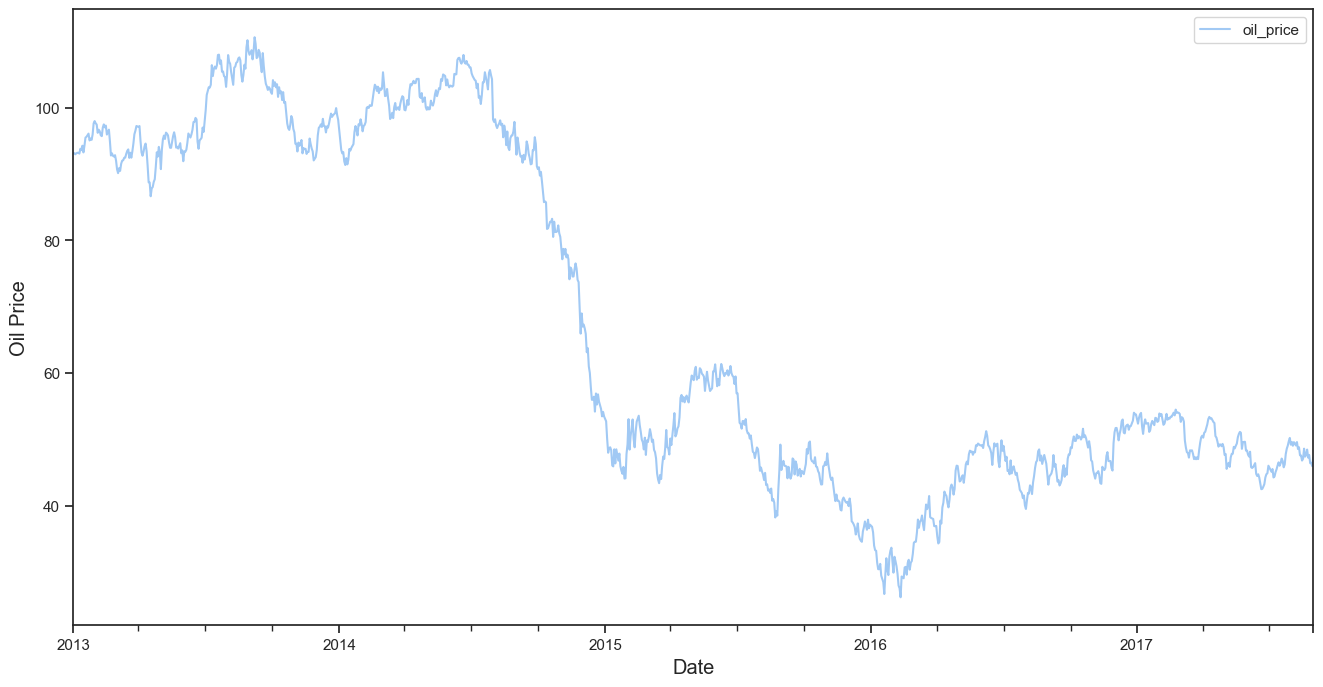

In [68]:
ax = df_oil.set_index('date').plot(figsize = (16, 8))
ax.set_xlabel('Date', fontsize = 'large')
ax.set_ylabel('Oil Price', fontsize = 'large')

Dip in mid-2014 to early 2015 was primarily driven by supply factors, including booming U.S. oil production, receding geopolitical concerns, and shifting OPEC policies. \
In November 2014, OPEC announced a new strategy geared towards improving its market share. Oil-market analysts interpreted this as an attempt to squeeze higher-cost \
producers including US shale oil out of the market. Over the next year, crude oil prices crashed, with large repercussions for the global economy.

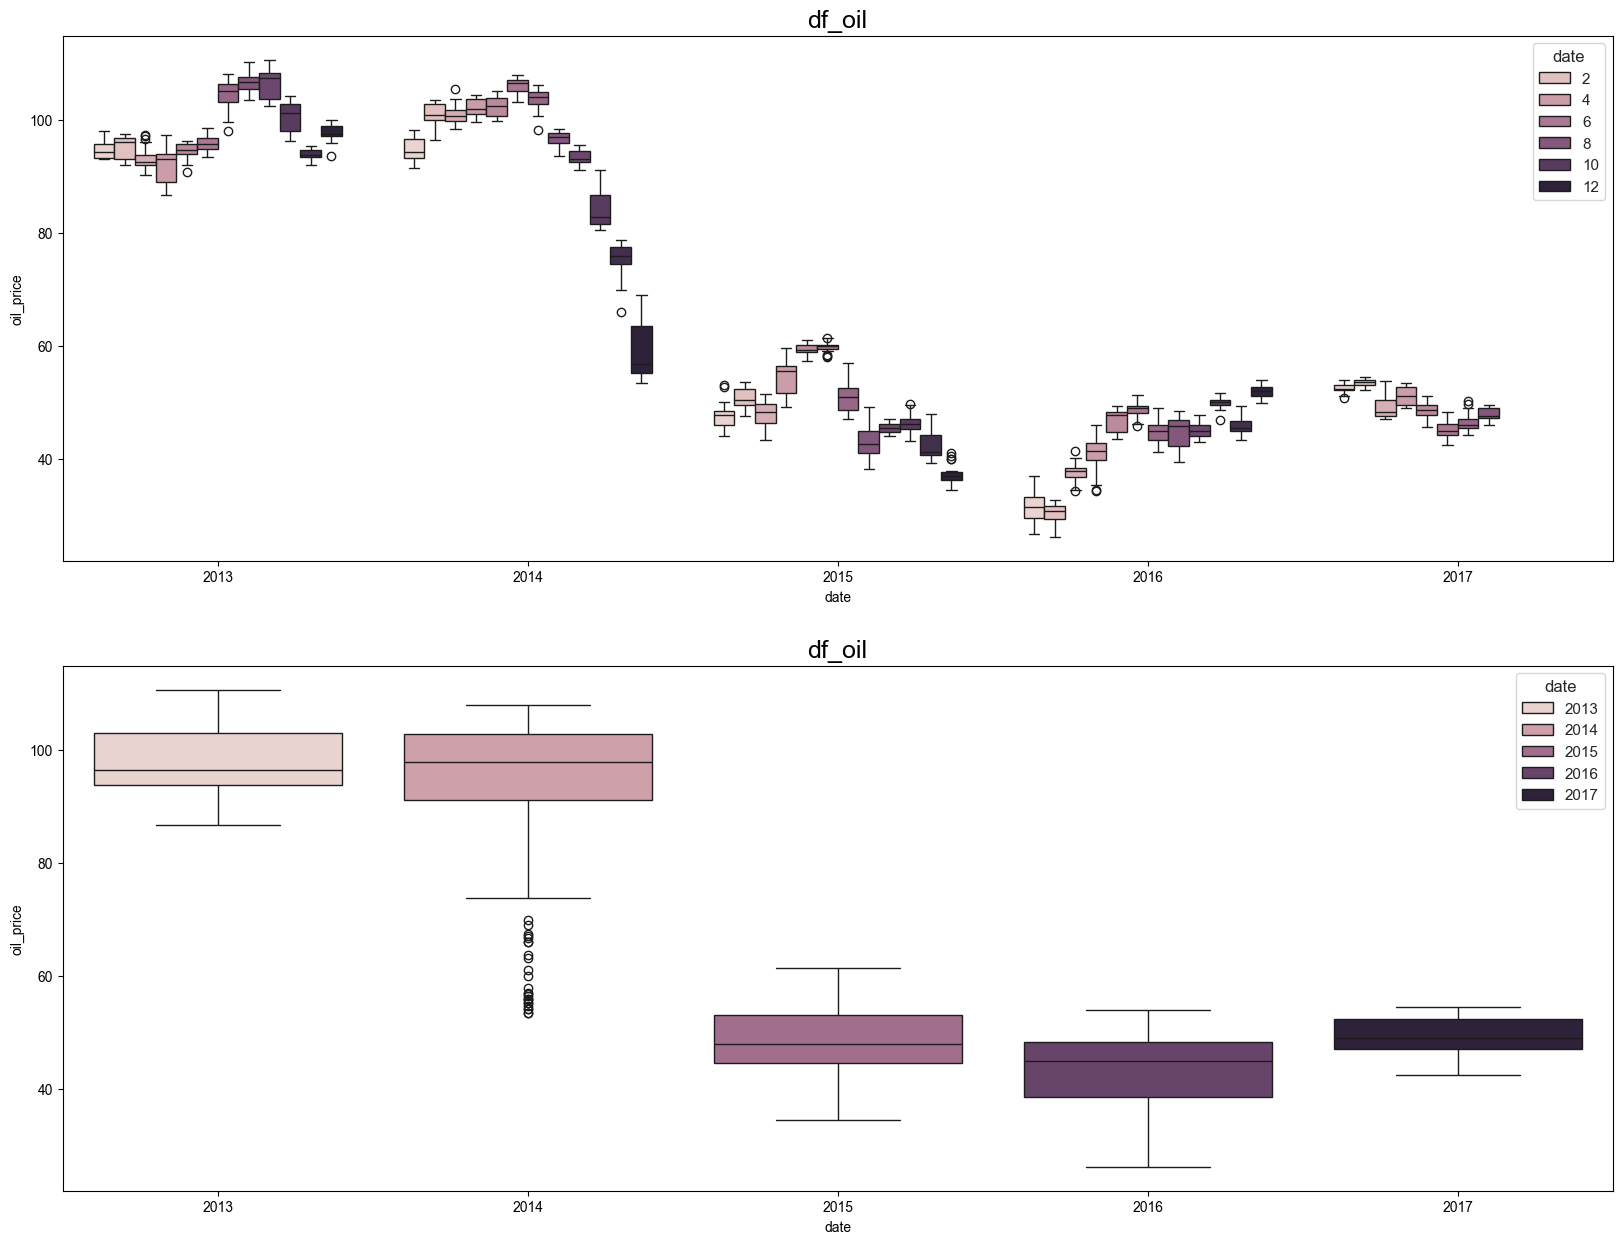

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
plot_boxplot('pastel', df_oil['date'].dt.year, df_oil['oil_price'], df_oil['date'].dt.month, axes[0], 'df_oil')
plot_boxplot('pastel', df_oil['date'].dt.year, df_oil['oil_price'], df_oil['date'].dt.year, axes[1], 'df_oil')

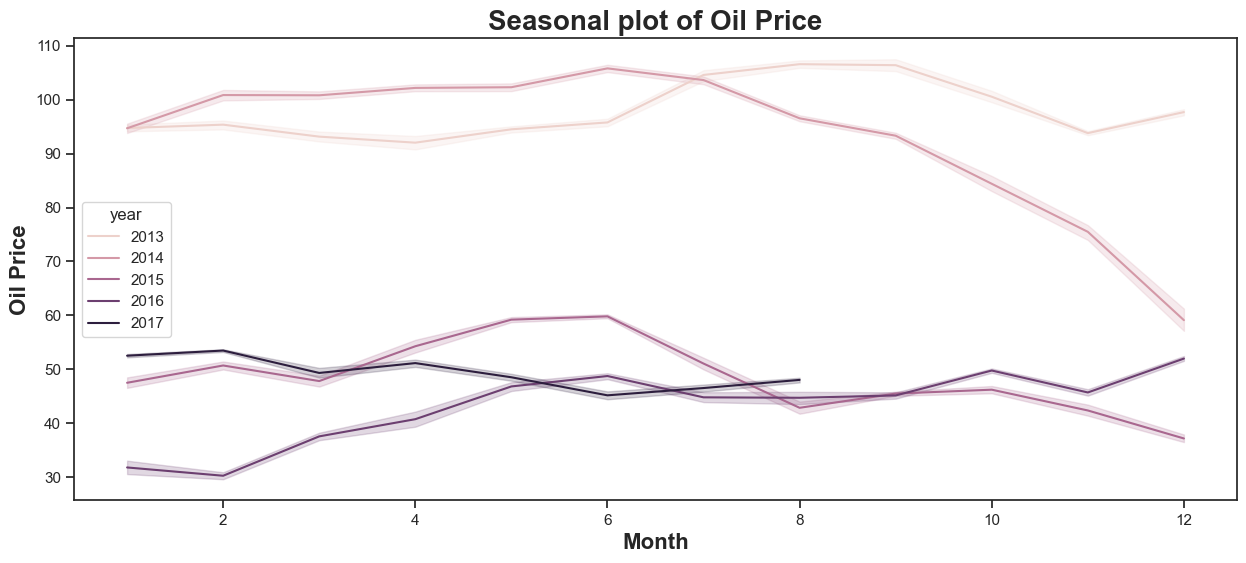

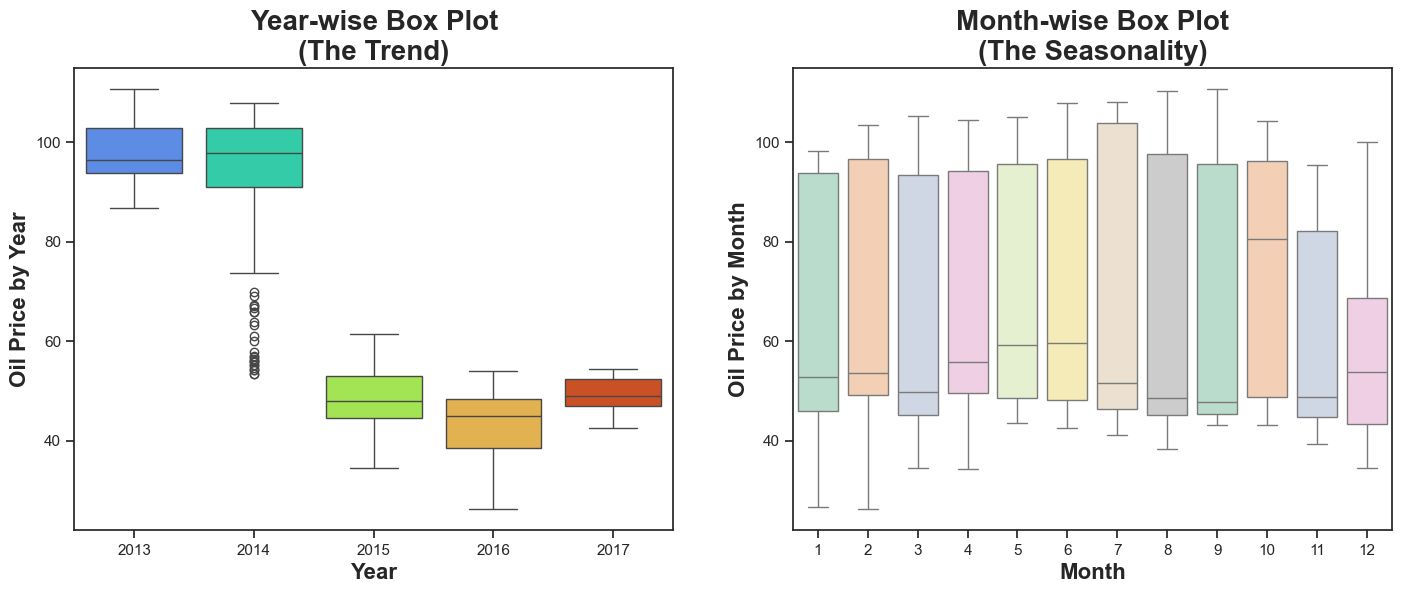

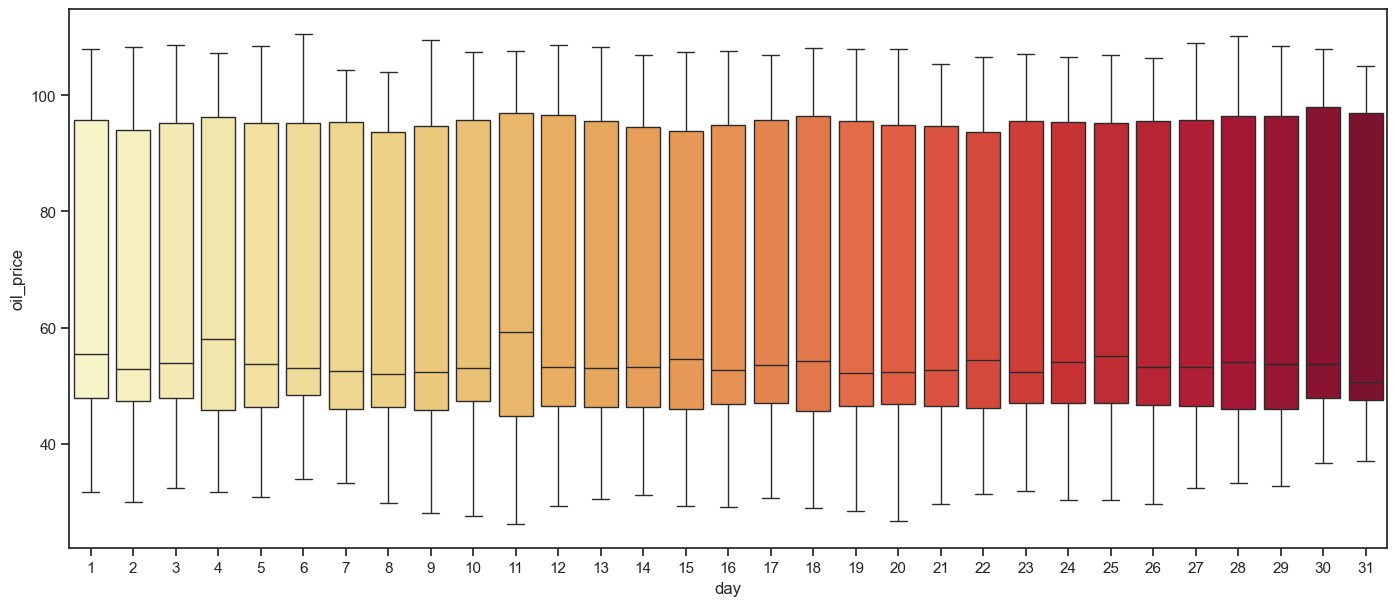

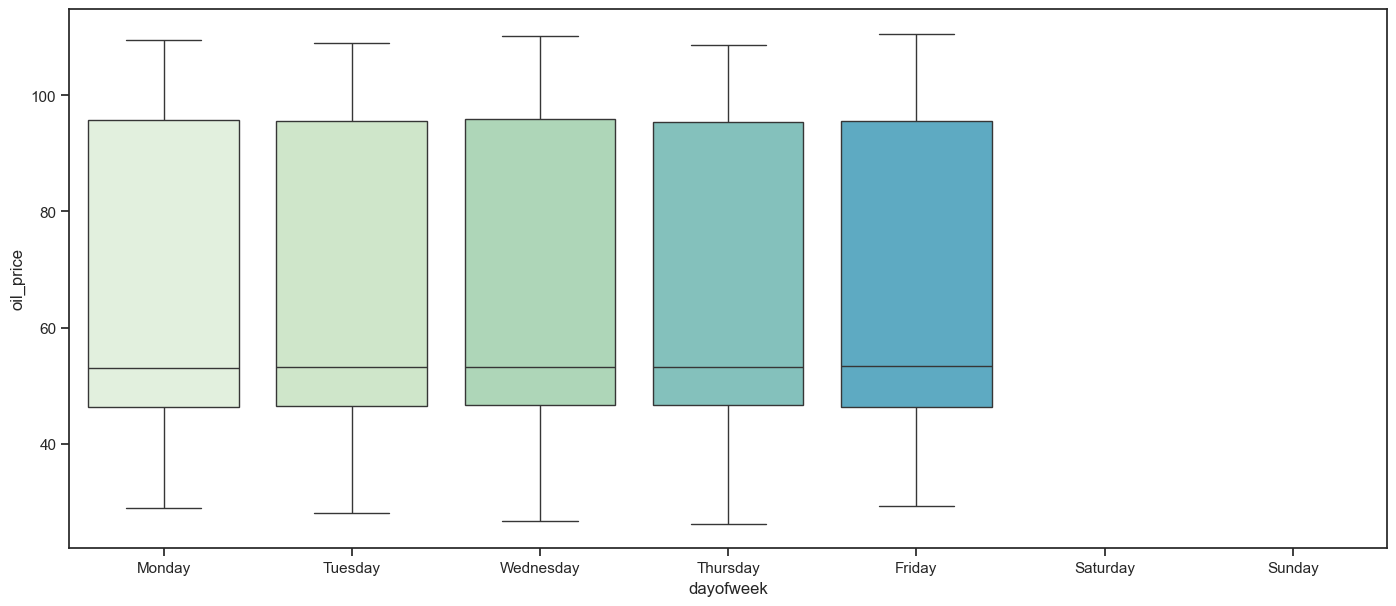

In [ ]:
get_seasonality_trend_overview(df_oil, 'oil_price', title_name='Oil Price')

## Transactions
Transaction data contains 3 attributes: **date**, **store_nbr** (store number where transactions took place) and **transactions** (number of transactions on a given date in a specified store).

In [ ]:
df_transactions.head()

date  store_nbr  transactions
1    2013-01-02          1          2111
47   2013-01-03          1          1833
93   2013-01-04          1          1863
139  2013-01-05          1          1509
185  2013-01-06          1           520

In [ ]:
df_transactions['date'] = pd.to_datetime(df_transactions.date)
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83488 entries, 1 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.5 MB


Text(0.5, 1.0, 'Distribution : Transactions')

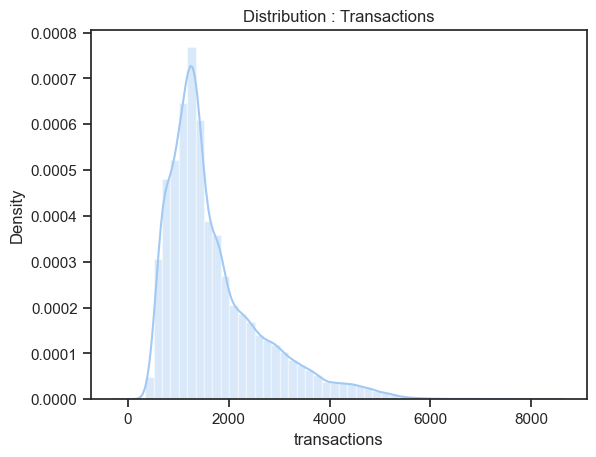

In [ ]:
sns.distplot(df_transactions['transactions'])
plt.title('Distribution : Transactions')

       transactions
month              
1          12156198
2          11707934
3          12917913
4          12633531
5          13112679
6          12482179
7          12827206
8          11545571
9           9811819
10         10048234
11          9877873
12         12357808
      transactions
year              
2013      29107173
2014      30006929
2015      31312370
2016      31052337
2017      20000136
            transactions
year month              
2013 1           2289558
     2           2169615
     3           2458683
     4           2344905
     5           2467465
     6           2392206
     7           2401968
     8           2461139
     9           2380462
     10          2408440
     11          2369866
     12          2962866
2014 1           2393528
     2           2278167
     3           2545427
     4           2455666
     5           2503262
     6           2399144
     7           2442341
     8           2537572
     9           2449131
     10     

Text(0, 0.5, 'Transactions')

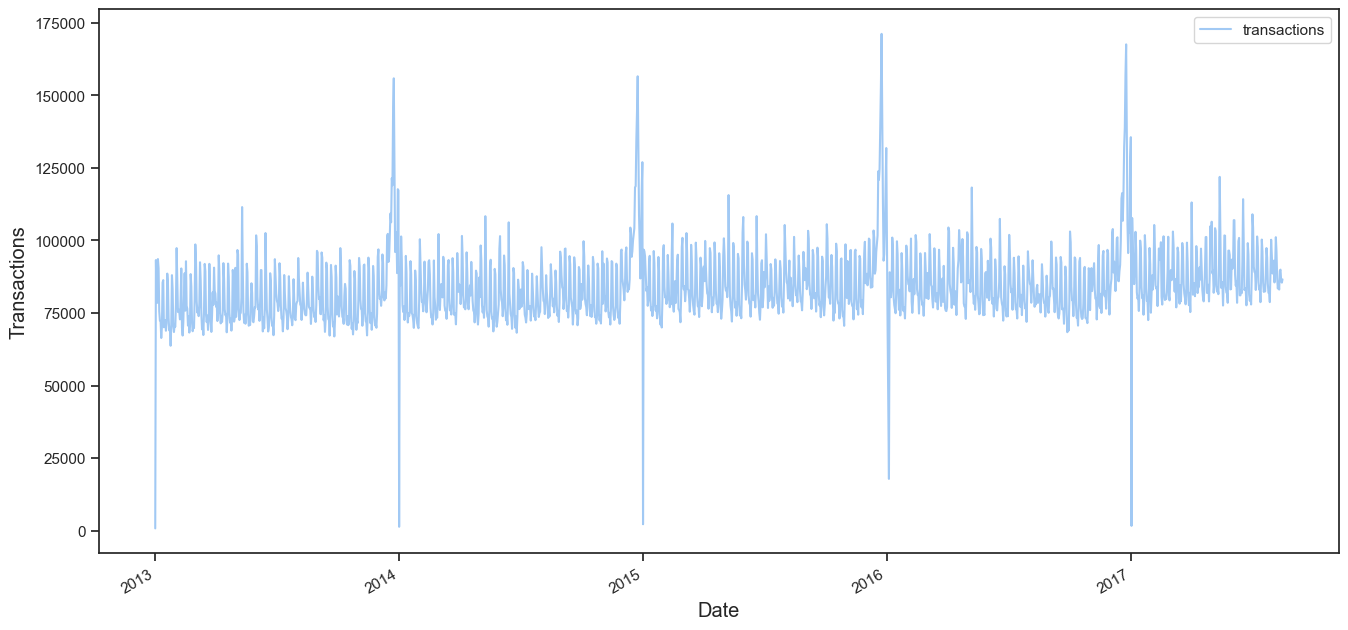

In [ ]:
ax = df_transactions.groupby(['date'])[['transactions']].sum().plot(figsize = (16, 8))
df_transactions_copy = df_transactions.copy()
df_transactions_copy['year'] = df_transactions.date.dt.year
df_transactions_copy['month'] = df_transactions.date.dt.month
print(df_transactions_copy.groupby(['month'])[['transactions']].sum())
print(df_transactions_copy.groupby(['year'])[['transactions']].sum())
print(df_transactions_copy.groupby(['year', 'month'])[['transactions']].sum())
ax.set_xlabel('Date', fontsize = 'large')
ax.set_ylabel('Transactions', fontsize = 'large')

Every year transactions peak in December

Spearman Correlation between Total Sales and Transactions: 0.8175


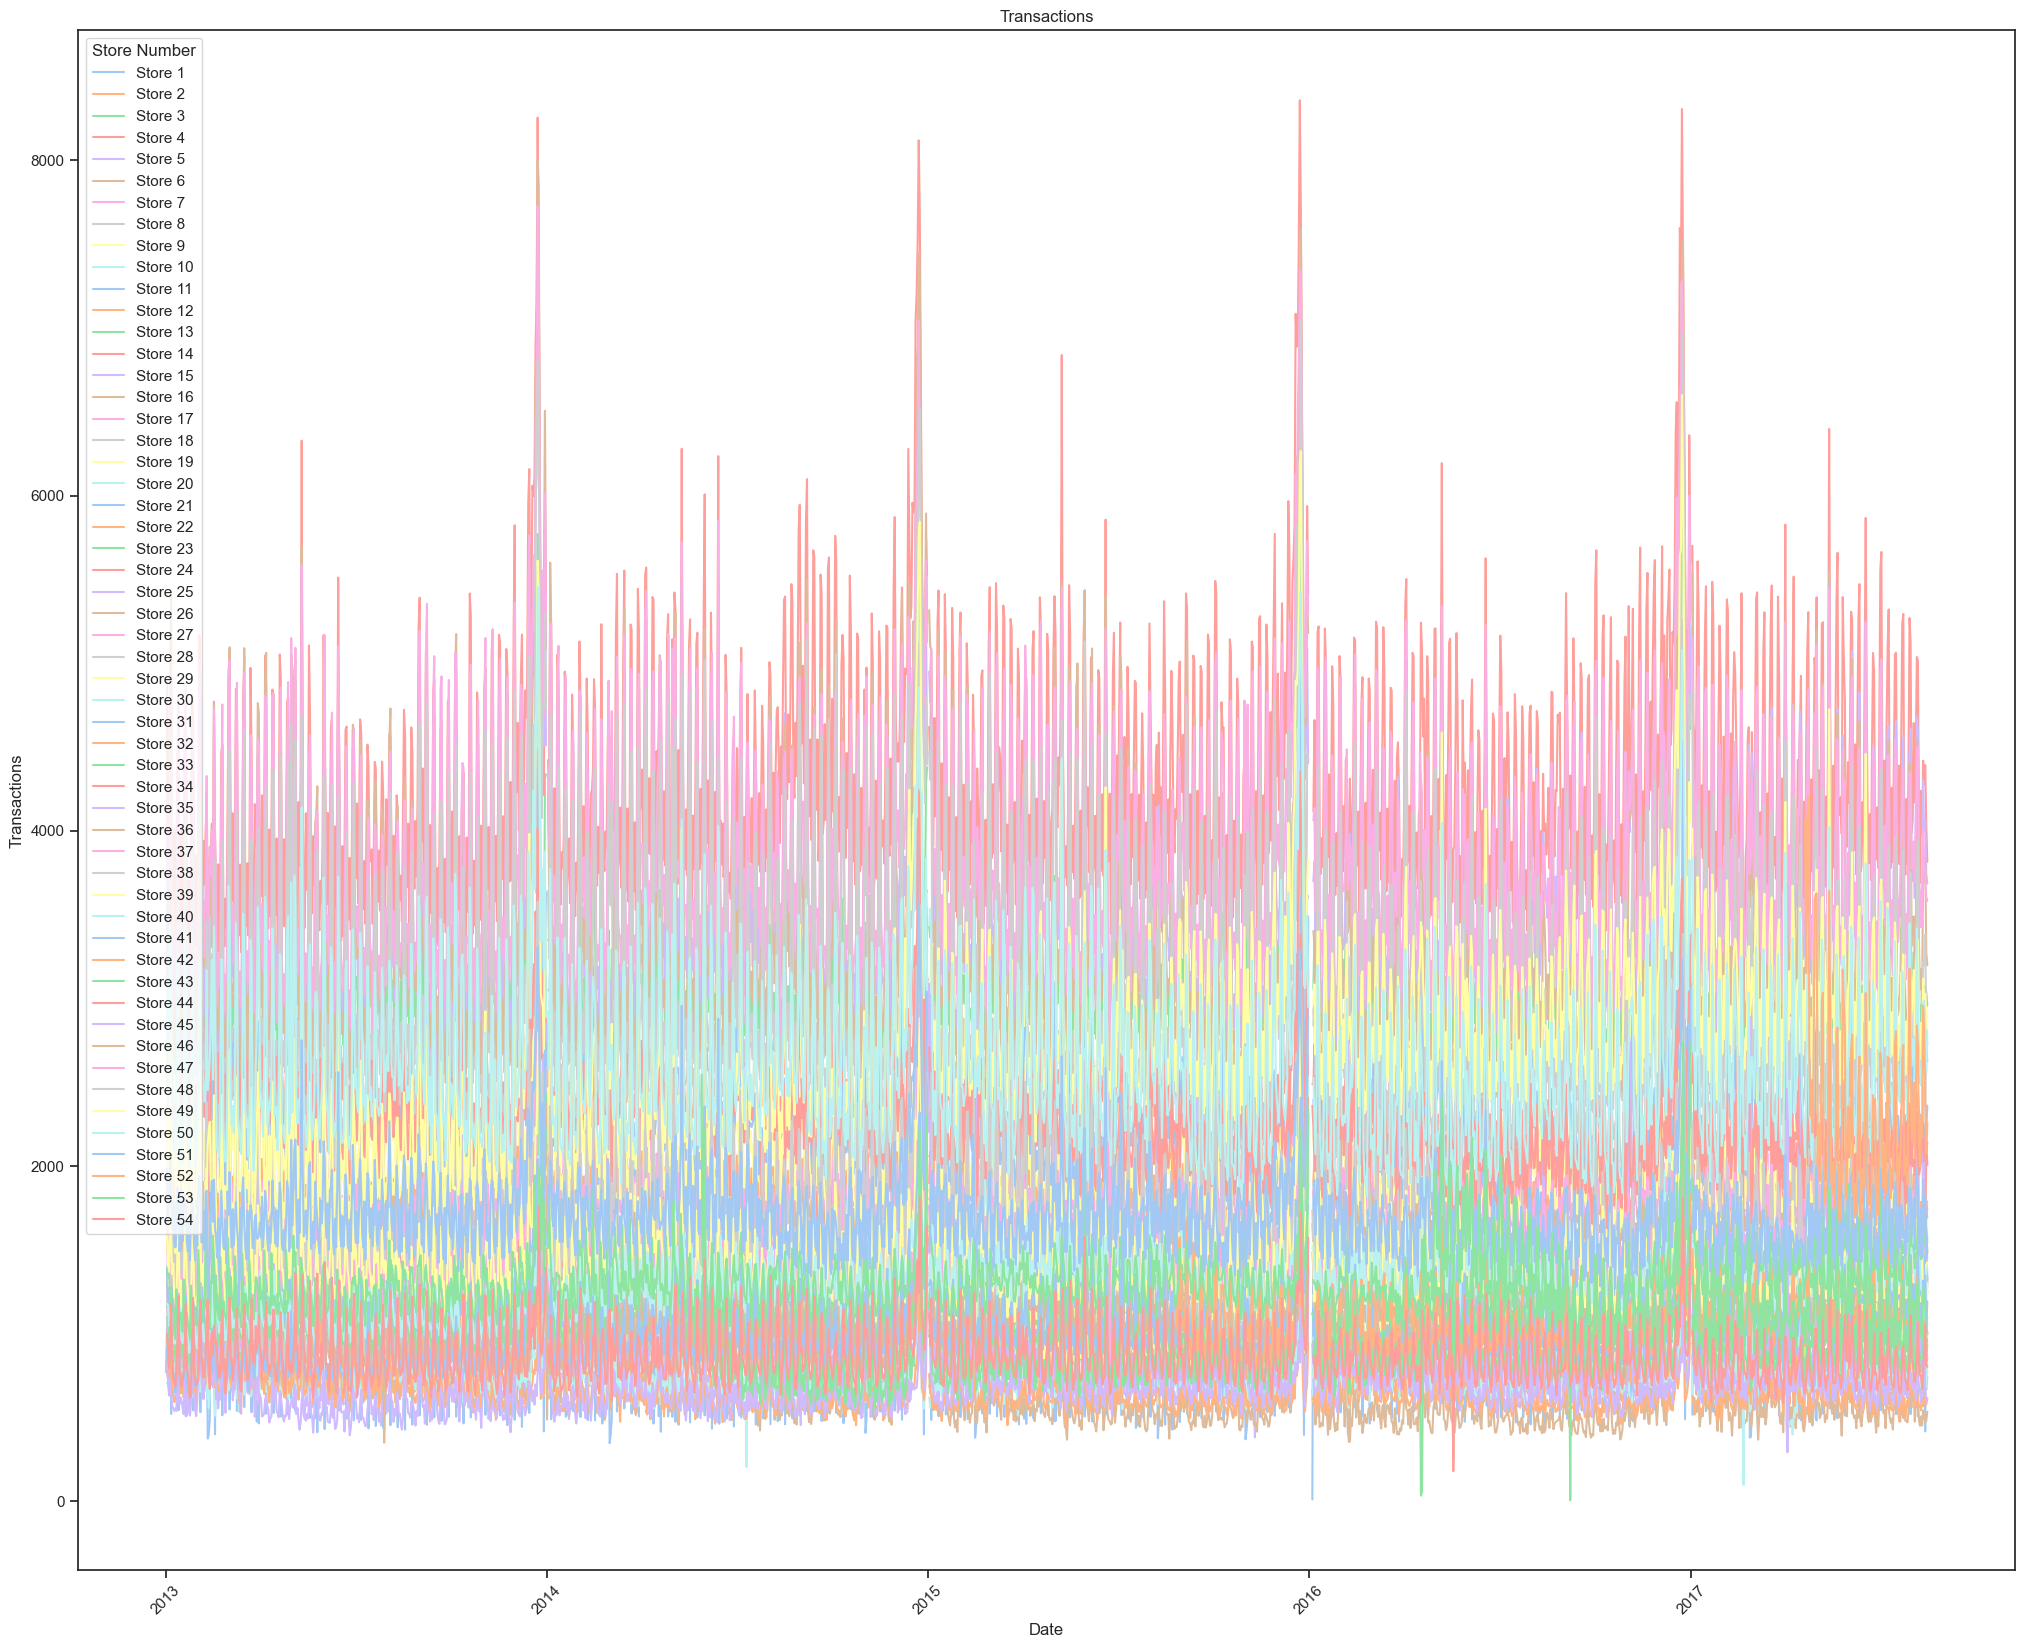

In [ ]:
df_train['date'] = pd.to_datetime(df_train.date)

# merge train data and transactions data to check transaction/sales correlation
temp = pd.merge(df_train.groupby(['date', 'store_nbr']).sales.sum().reset_index(), df_transactions, how = 'left')
print('Spearman Correlation between Total Sales and Transactions: {:,.4f}'.format(temp.corr('spearman').sales.loc['transactions']))

transactions_sorted = temp.sort_values(['store_nbr', 'date'])

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(25, 20))

# Plot each store's transactions
for store_nbr, data in transactions_sorted.groupby('store_nbr'):
    ax.plot(data['date'], data['transactions'], label=f'Store {store_nbr}')

# Set the title and labels
ax.set_title('Transactions')
ax.set_xlabel('Date')
ax.set_ylabel('Transactions')
ax.legend(title='Store Number')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()

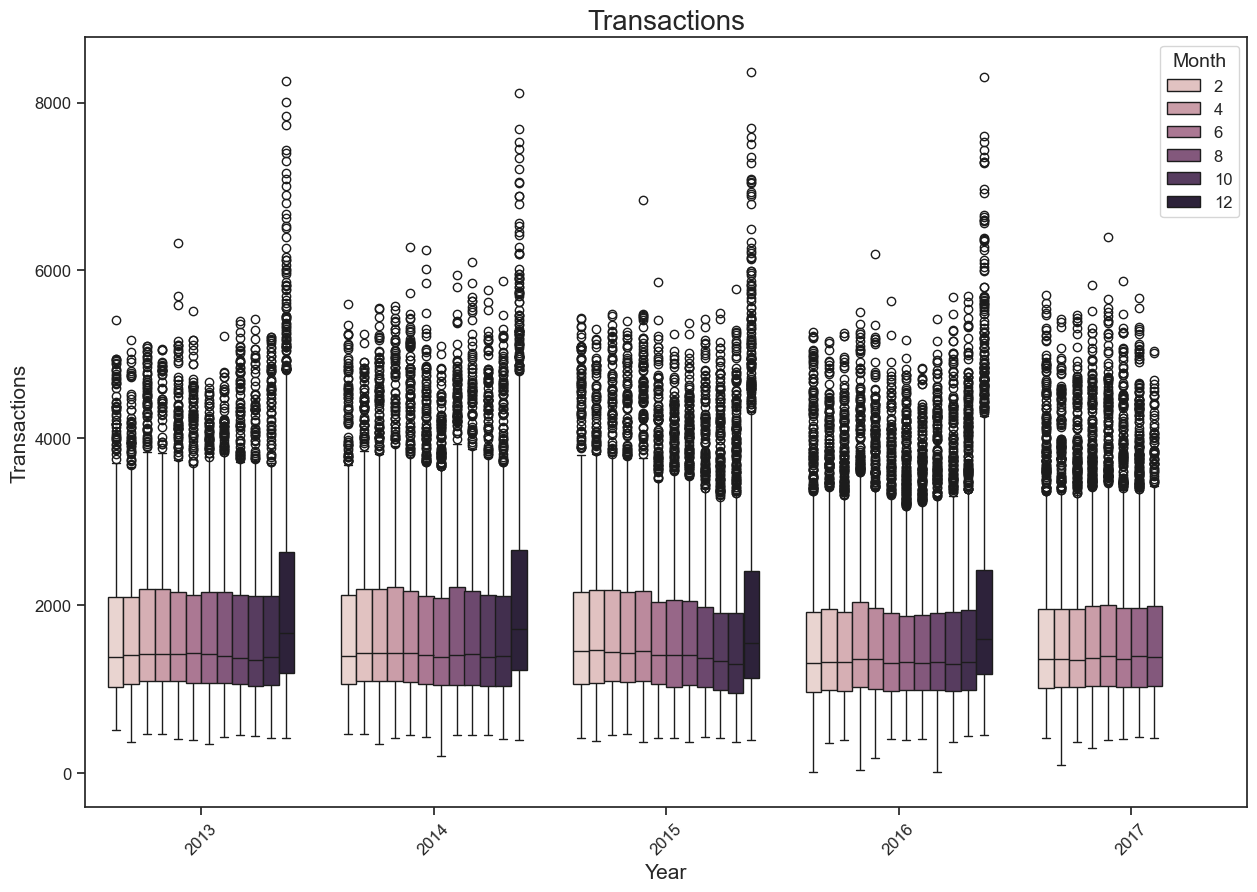

In [ ]:
temp = df_transactions.copy()
temp['year'] = temp.date.dt.year
temp['month'] = temp.date.dt.month
plt.figure(figsize=(15, 10))

# Create a boxplot with Seaborn
sns.boxplot(data=temp, x='year', y='transactions', hue='month')

# Set the title and labels
plt.title('Transactions', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Transactions', fontsize=15)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='Month', fontsize=12, title_fontsize=14)
plt.show()

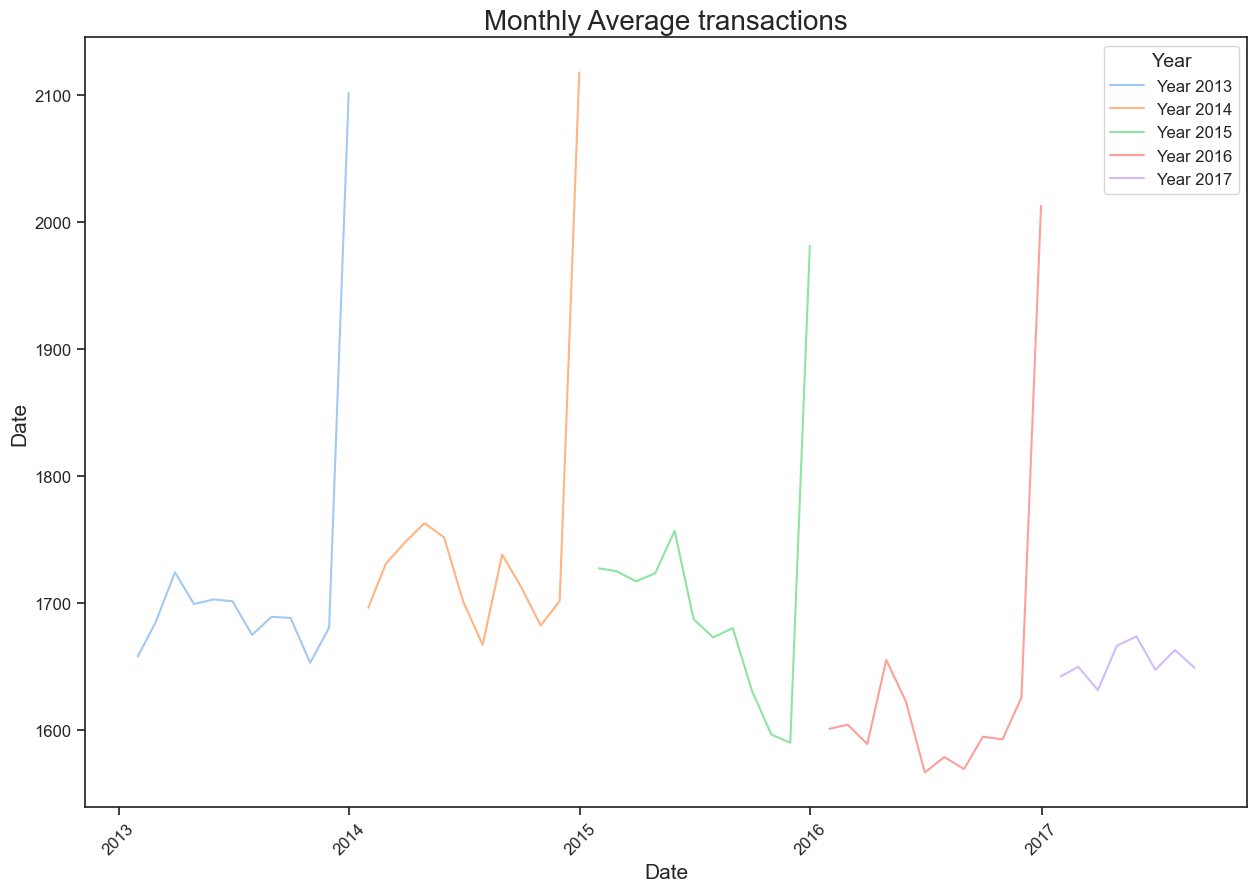

In [ ]:
plot_period_mean(df_transactions, 'transactions', period='M')

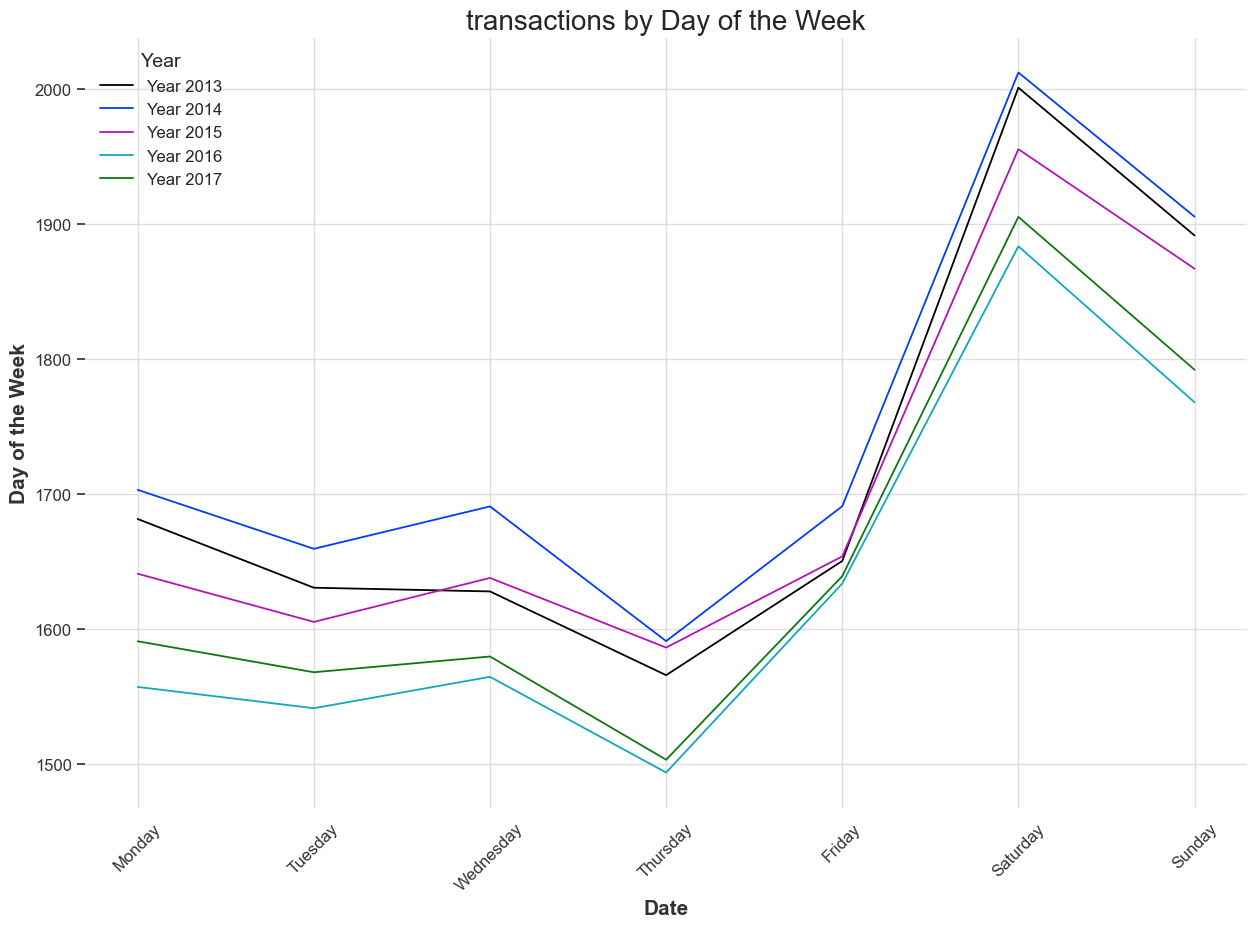

In [155]:
plot_period_mean(df_transactions, 'transactions', period='DW')

Highest number of transactions are during weekends with a peak on Saturday

## Stores
Stores data contains 5 attributes: **store_nbr**, **city**, **state**, **type**, **cluster**.

In [ ]:
df_stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [ ]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [ ]:
df_stores['city'].value_counts()

city
Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: count, dtype: int64

In [ ]:
df_stores['type'].value_counts()

type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

## Holidays
Holidays data contains 6 attributes: **date**, **type**, **locale**, **locale_name**, **description**, **transferred**.

In [ ]:
df_holidays.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [ ]:
df_holidays['date'] = pd.to_datetime(df_holidays.date)
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [ ]:
df_holidays.describe(include='O')

type    locale locale_name description
count       350       350         350         350
unique        6         3          24         103
top     Holiday  National     Ecuador    Carnaval
freq        221       174         174          10

In [ ]:
set(df_holidays.type.to_list())

{'Additional', 'Bridge', 'Event', 'Holiday', 'Transfer', 'Work Day'}

In [ ]:
set(df_holidays.locale.to_list())

{'Local', 'National', 'Regional'}

<Axes: title={'center': 'Counts of type of holiday'}, xlabel='locale', ylabel='count'>

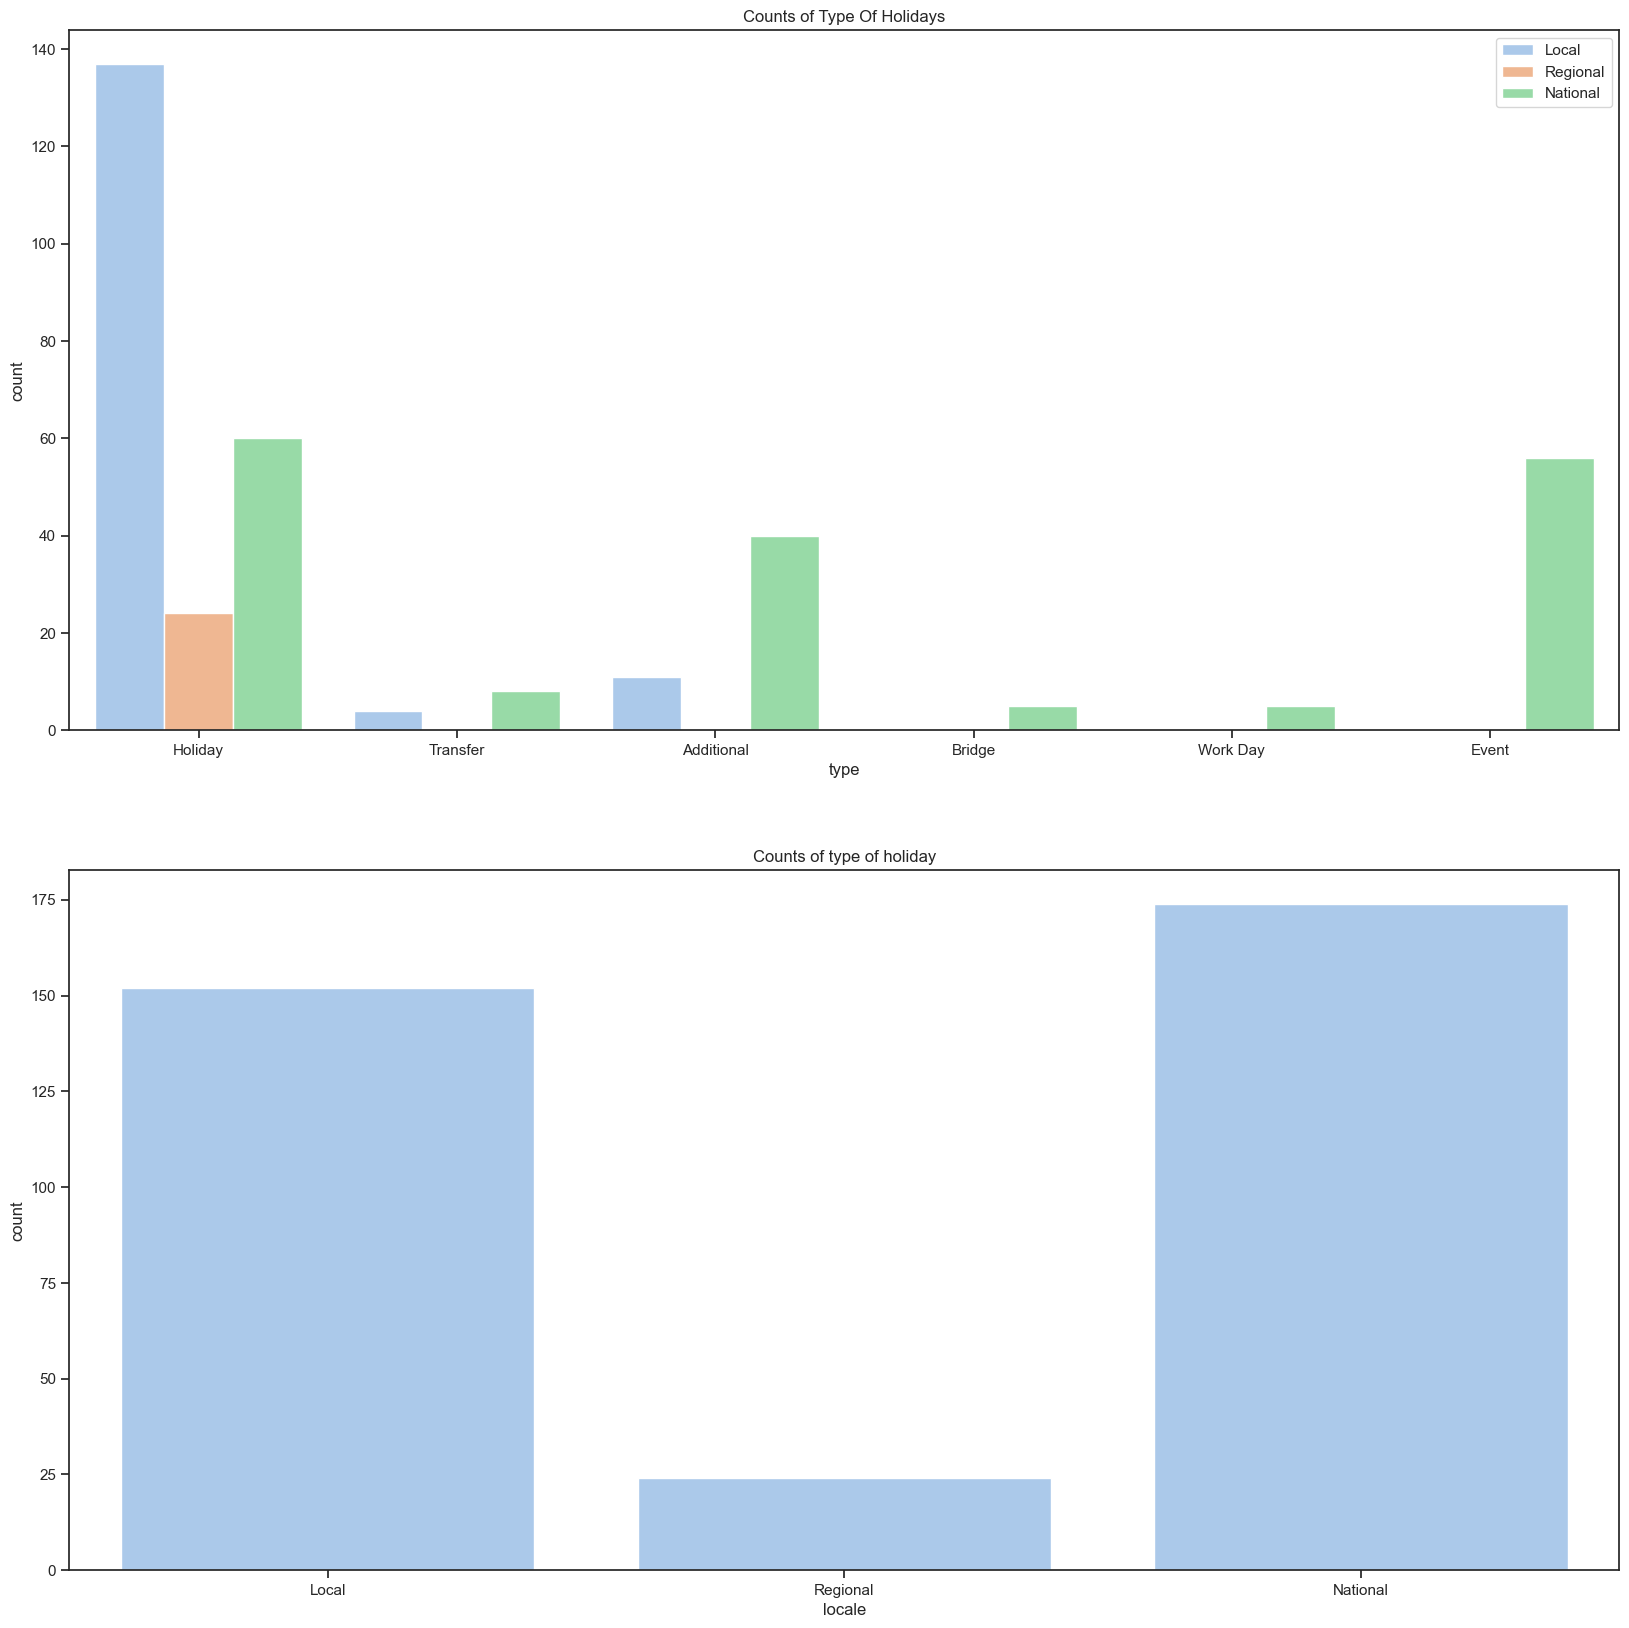

In [ ]:
plt.subplots(1,2,figsize=(20,20))
plt.subplot(211)
plt.title('Counts of Type Of Holidays')
sns.countplot(x=df_holidays.type, hue=df_holidays.locale)
plt.legend(loc='upper right')
plt.subplot(212)
plt.title('Counts of type of holiday')
sns.countplot(x=df_holidays.locale)

## Train Data
Train data contains 6 attributes: **id**, **date**, **store_nbr**, **family**, **sales**, **onpromotion**.

In [ ]:
df_train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

In [ ]:
df_train['date'] = pd.to_datetime(df_train.date)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [ ]:
df_train.describe()

id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703088384  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.502218e+05            2014-02-26 18:00:00  1.400000e+01   
50%    1.500444e+06            2015-04-24 12:00:00  2.750000e+01   
75%    2.250665e+06            2016-06-19 06:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000e+01   
std    8.662819e+05                            NaN  1.558579e+01   

              sales   onpromotion  
count  3.000888e+06  3.000888e+06  
mean   3.577757e+02  2.602770e+00  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    1.100000e+01  0.000000e+00  
75%    1.958473e+02  0.000000e+00  
max    1.247170e+05  7.410000e+02  
std    1.101998e+03  1.221888e+01

In [ ]:
print(set(df_train.family.to_list()))
len(set(df_train.family.to_list()))

{'HOME APPLIANCES', 'BEVERAGES', 'SCHOOL AND OFFICE SUPPLIES', 'CELEBRATION', 'PRODUCE', 'AUTOMOTIVE', 'LIQUOR,WINE,BEER', 'GROCERY II', 'PET SUPPLIES', 'BREAD/BAKERY', 'MEATS', 'POULTRY', 'HOME AND KITCHEN II', 'EGGS', 'BABY CARE', 'PLAYERS AND ELECTRONICS', 'GROCERY I', 'HARDWARE', 'PERSONAL CARE', 'CLEANING', 'LINGERIE', 'BEAUTY', 'LAWN AND GARDEN', 'SEAFOOD', 'DAIRY', 'LADIESWEAR', 'HOME CARE', 'HOME AND KITCHEN I', 'BOOKS', 'MAGAZINES', 'PREPARED FOODS', 'FROZEN FOODS', 'DELI'}


33

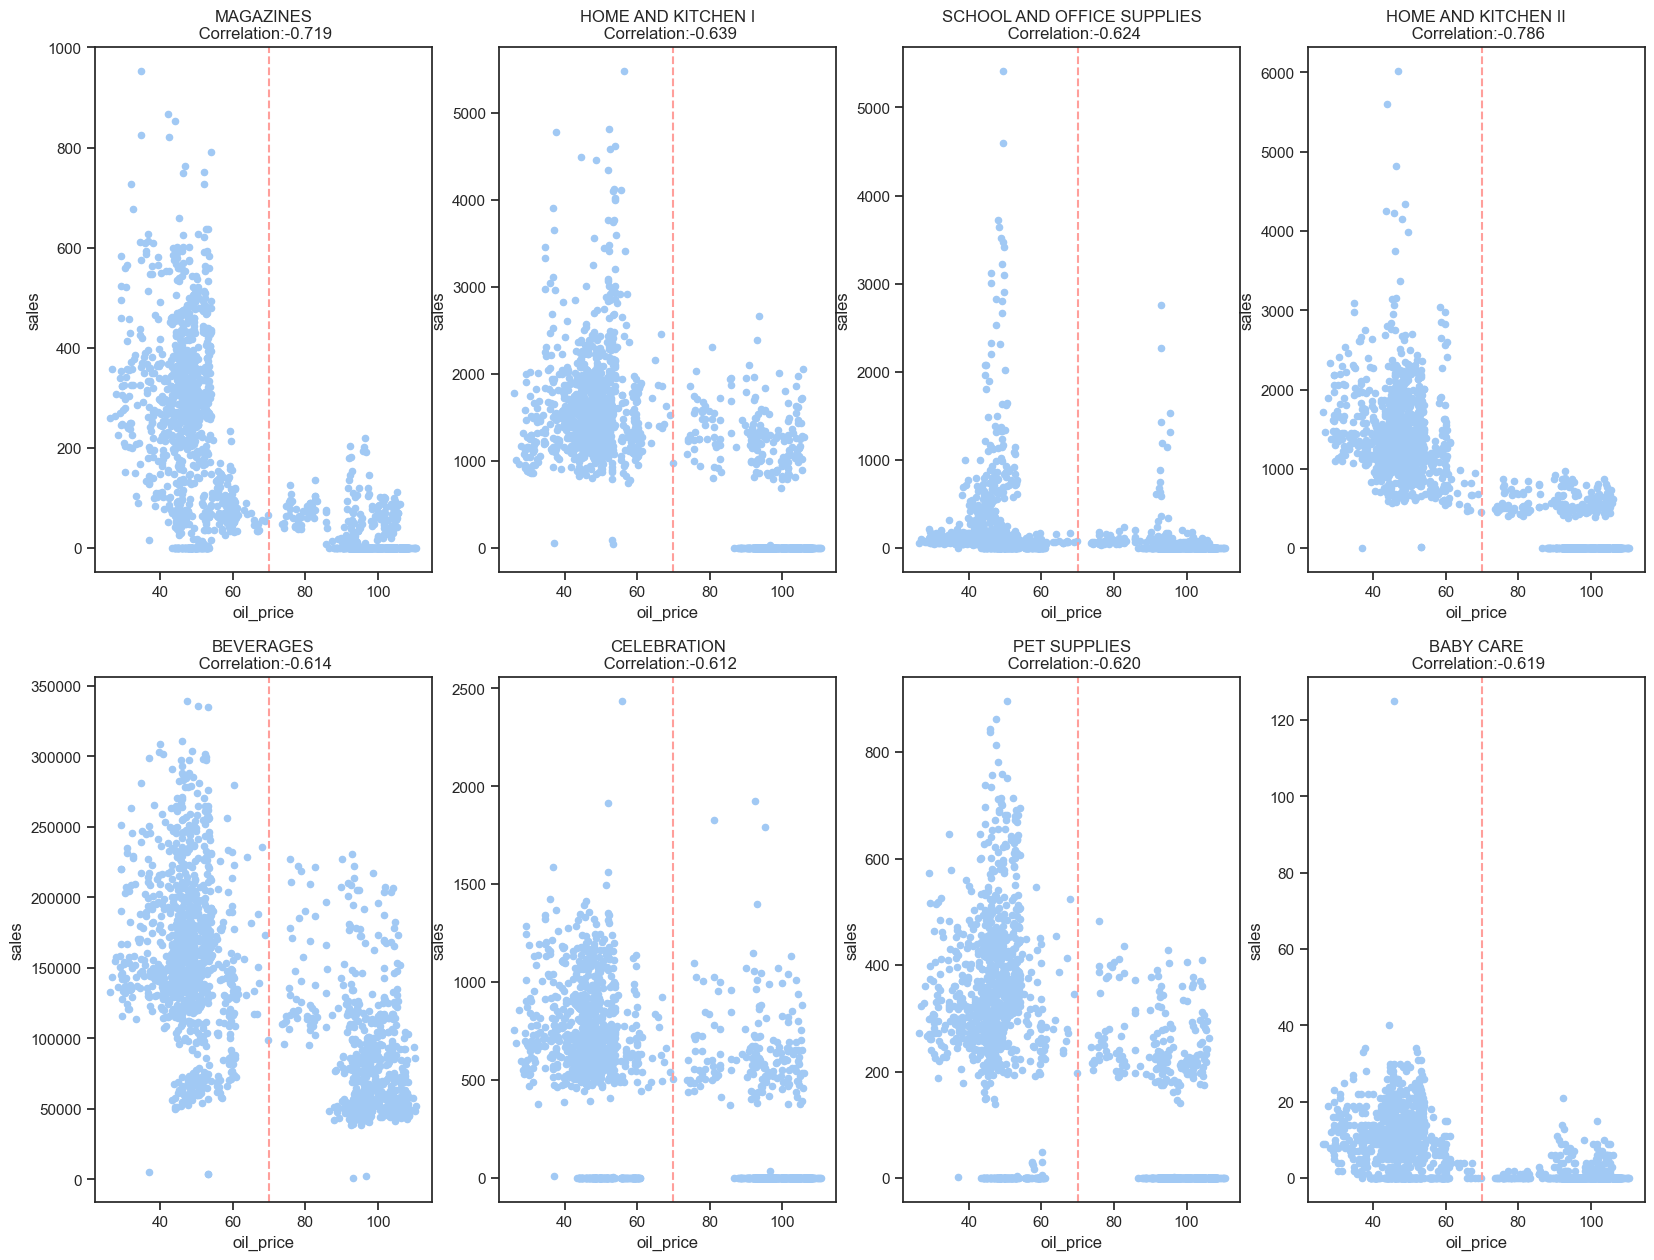

In [ ]:
oil = df_oil.copy()
# Resample -> index is now date and if there is entry missing for some date it will be 0 for oil_prices
oil = oil.set_index('date').oil_price.resample('D').sum().reset_index()

# Interpolate
oil['oil_price'] = np.where(oil['oil_price'] == 0, np.nan, oil['oil_price'])
oil['oil_price'] = oil.oil_price.interpolate()

# merge train data and oil data
a = pd.merge(df_train.groupby(['date', 'family']).sales.sum().reset_index(), oil, how = 'left')
c = a.groupby('family').corr('spearman').reset_index()
c = c[c.level_1 == 'oil_price'][['family', 'sales']].sort_values('sales')

# extract only statisticaly significant correlations
df_significant_corelation = c[(c['sales'] >= 0.6) | (c['sales'] <= -0.6)]
df_significant_corelation

# we make 2x4 matrix of plots
fig, axes = plt.subplots(2, 4, figsize=(20, 15))
for i, family in enumerate(df_significant_corelation.family):
    if i < 4:
         a[a.family == family].plot.scatter(x = 'oil_price', y = 'sales', ax=axes[0, i-1])
         axes[0, i-1].set_title(family+'\n Correlation:'+str(df_significant_corelation[df_significant_corelation.family == family].sales.iloc[0])[:6], fontsize = 12)
         axes[0, i-1].axvline(x=70, color='r', linestyle='--')
    else:
         a[a.family == family].plot.scatter(x = 'oil_price', y = 'sales', ax=axes[1, i-6])
         axes[1, i-6].set_title(family+'\n Correlation:'+str(df_significant_corelation[df_significant_corelation.family == family].sales.iloc[0])[:6], fontsize = 12)
         axes[1, i-6].axvline(x=70, color='r', linestyle='--')

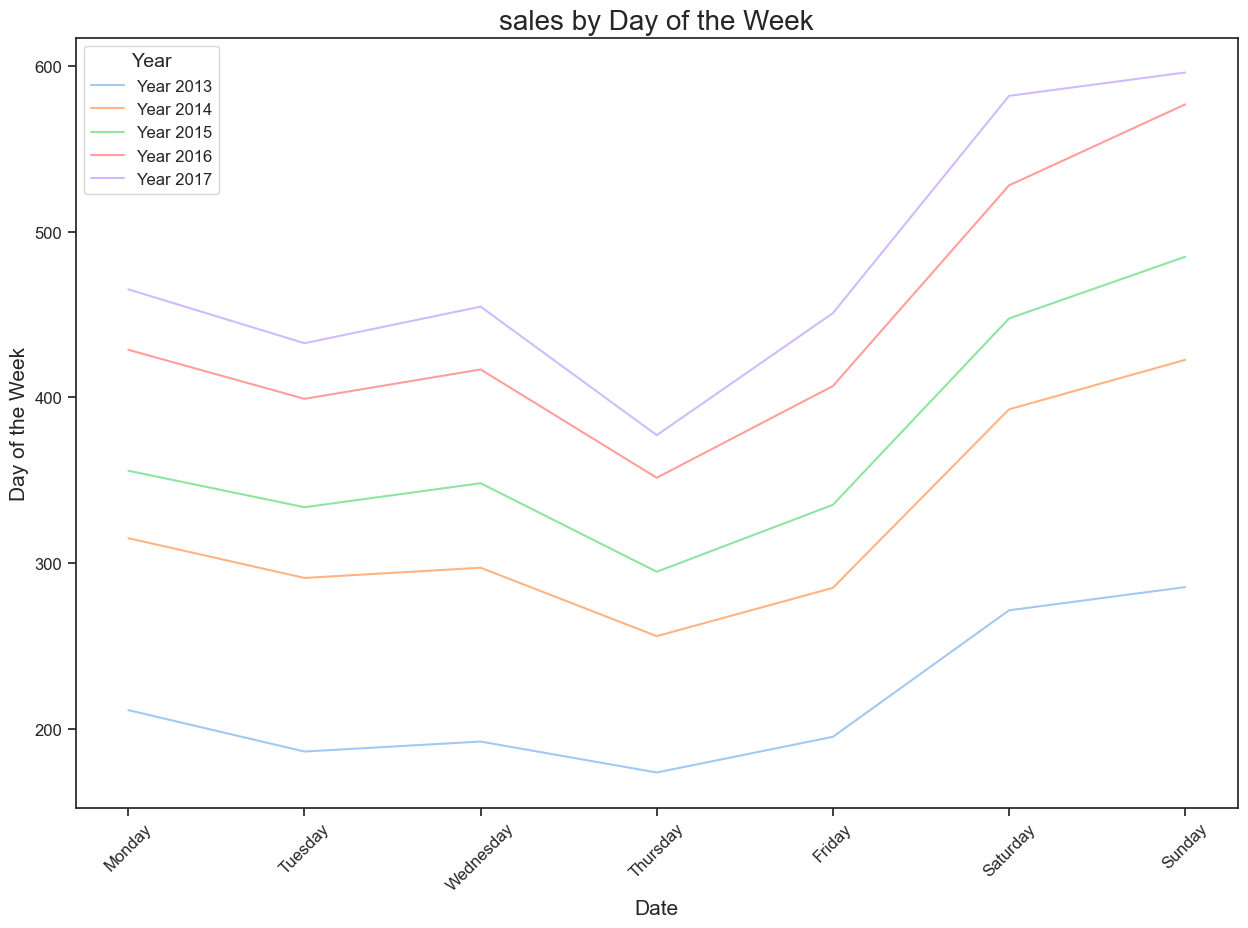

In [ ]:
plot_period_mean(df_train, 'sales', period='DW')

Peaks are during weekends

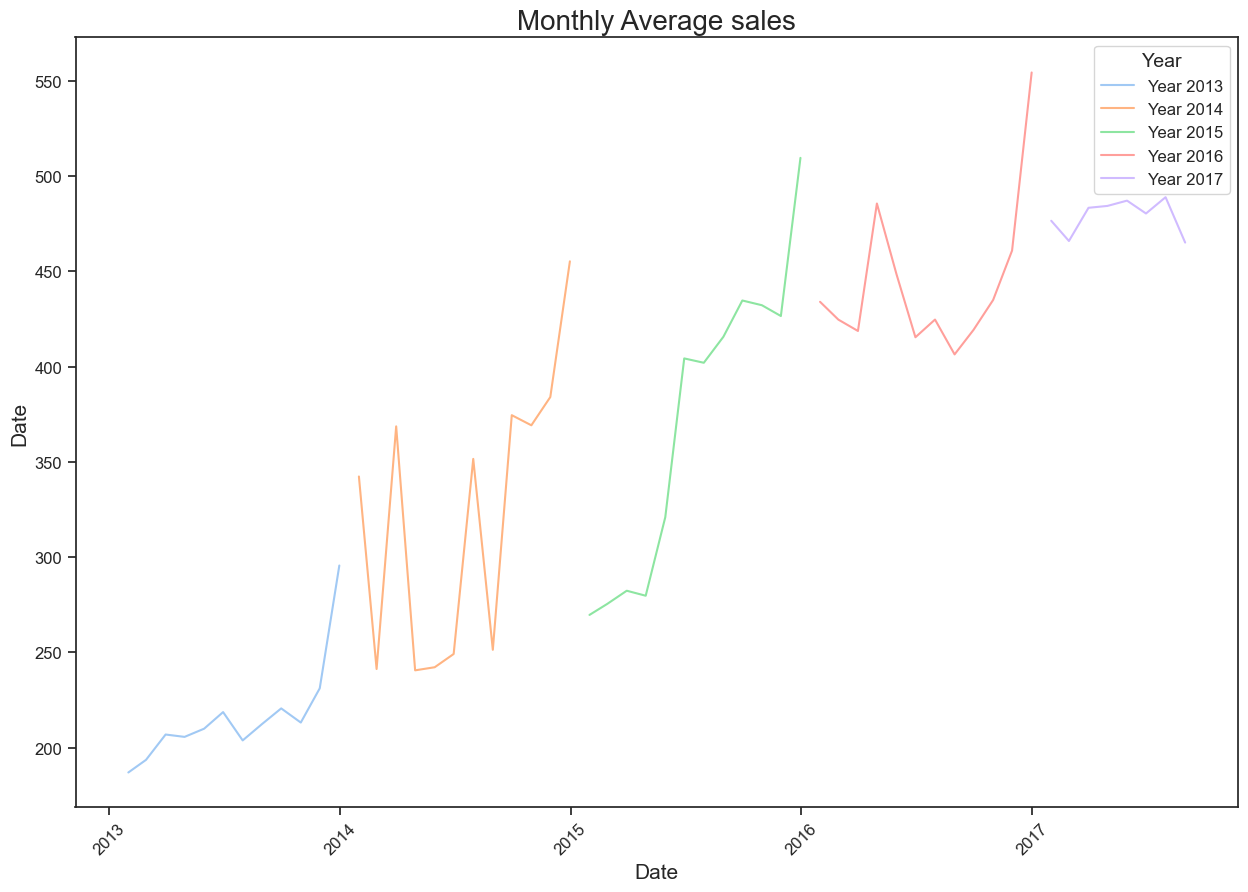

In [ ]:
plot_period_mean(df_train, 'sales', period='M')

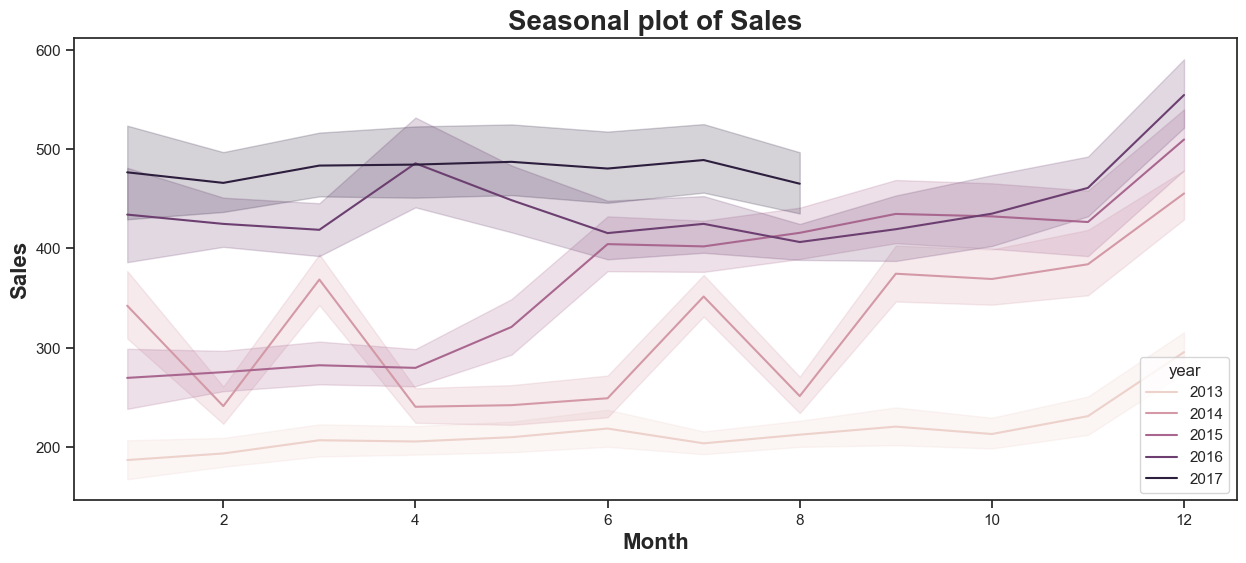

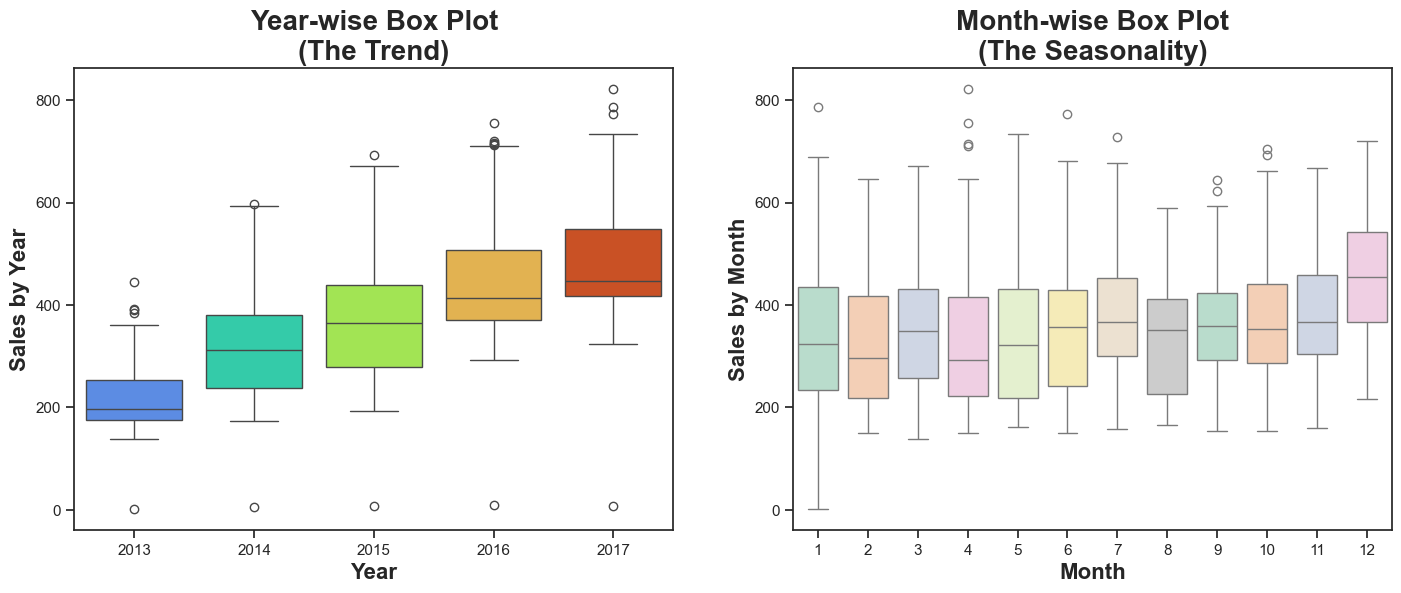

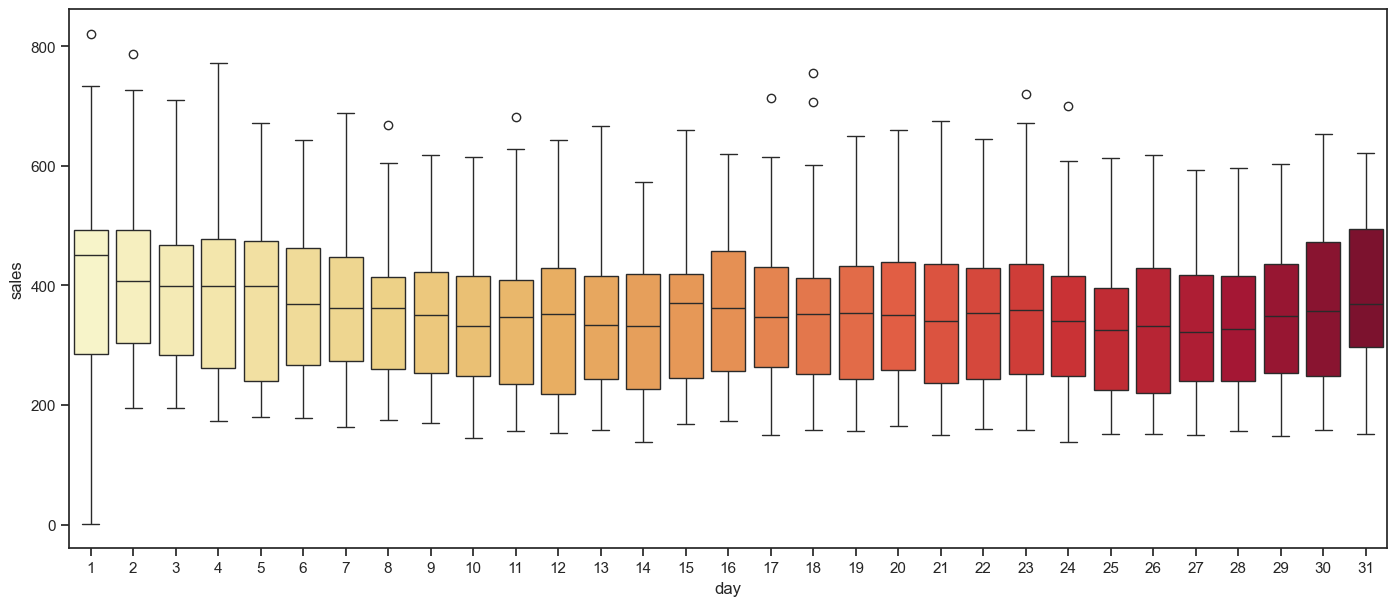

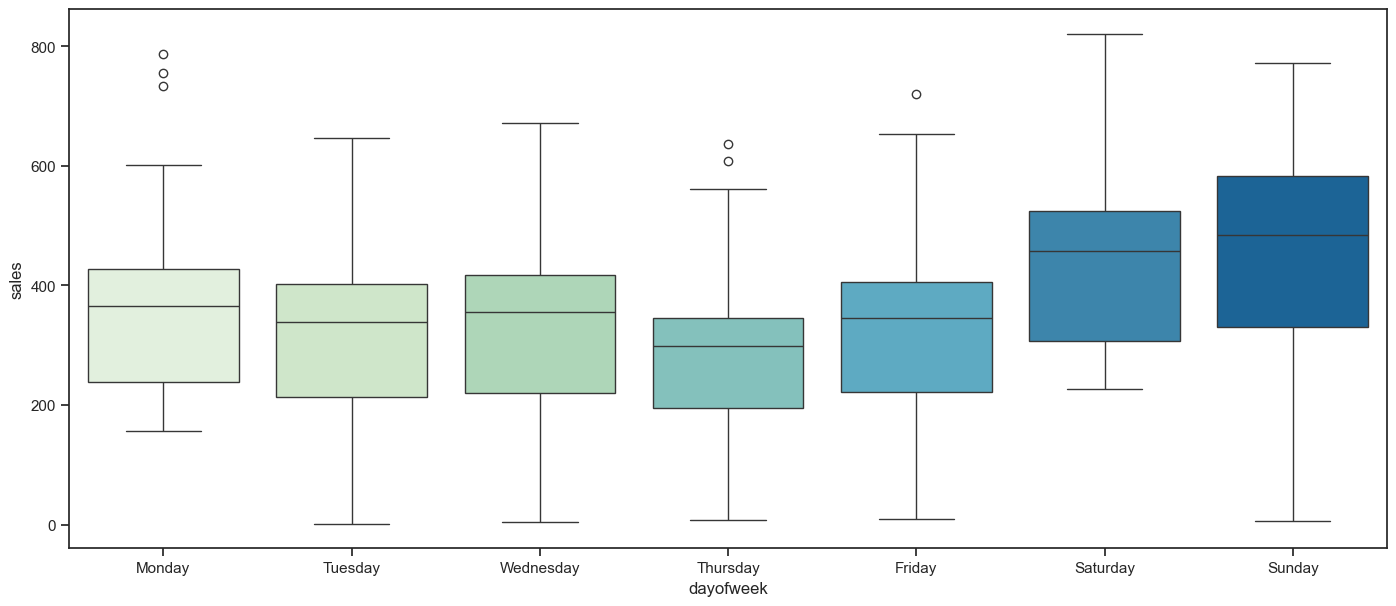

In [ ]:
get_seasonality_trend_overview(df_train.drop(columns='family'), 'sales', 'Sales')

## Zeros

In [ ]:
df_train_wide = pd.pivot(df_train, index=["date"], columns=["store_nbr","family"], values=["sales"])
df_train_wide.head()

sales                                                \
store_nbr          1                                                  
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

                                                                               \
store_nbr                                                                       
family     CELEBRATION CLEANING  DAIRY     DELI   EGGS FROZEN FOODS GROCERY I   
date                                                                            
2013-01-01         0.0      0.0    0.0    0.000    0.0        0.000       0.0   
2013-01-02         0.0   1060.0  579.0  164.069  246.0      131.000    2652.0   
2013-01-03         0.0    836.0  453.0  151.582  203.0       87.044    2121.0   
2013-01-04         0.0    827.0  460.0  131.411  171.0       65.000    2056.0   
2013-01-05         0.0    811.0  464.0  118.613  177.0       70.000    2216.0   

                                                                       \
store_nbr                                                               
family     GROCERY II HARDWARE HOME AND KITCHEN I HOME AND KITCHEN II   
date                                                                    
2013-01-01        0.0      0.0                0.0                 0.0   
2013-01-02       31.0      3.0                0.0                 0.0   
2013-01-03       12.0      1.0                0.0                 0.0   
2013-01-04       15.0      7.0                0.0                 0.0   
2013-01-05       30.0      1.0                0.0                 0.0   

                                                                          \
store_nbr                                                                  
family     HOME APPLIANCES HOME CARE LADIESWEAR LAWN AND GARDEN LINGERIE   
date                                                                       
2013-01-01             0.0       0.0        0.0             0.0      0.0   
2013-01-02             0.0       0.0        0.0            10.0     13.0   
2013-01-03             2.0       0.0        0.0             0.0     15.0   
2013-01-04             0.0       0.0        0.0             7.0     24.0   
2013-01-05             0.0       0.0        0.0            10.0     20.0   

                                                                           \
store_nbr                                                                   
family     LIQUOR,WINE,BEER MAGAZINES    MEATS PERSONAL CARE PET SUPPLIES   
date                                                                        
2013-01-01              0.0       0.0    0.000           0.0          0.0   
2013-01-02             67.0       0.0  369.101         194.0          0.0   
2013-01-03             66.0       0.0  272.319         153.0          0.0   
2013-01-04            102.0       0.0  454.172          88.0          0.0   
2013-01-05            159.0       0.0  328.940         141.0          0.0   

                                                                      \
store_nbr                                                              
family     PLAYERS AND ELECTRONICS    POULTRY PREPARED FOODS PRODUCE   
date                                                                   
2013-01-01                     0.0    0.00000            0.0     0.0   
2013-01-02                     0.0  247.29700           47.0     0.0   
2013-01-03                     0.0  187.27800           63.0     0.0   
2013-01-04                     0.0  258.02300           67.0     0.0   
2013-01-05                     0.

there are store-family pairs with all target zeros

In [ ]:
all_zeros = df_train_wide.loc[:, (df_train_wide == 0).all()]
all_zeros.head()

sales                                                          \
store_nbr         1     10    11    12        13          14                   
family     BABY CARE BOOKS BOOKS BOOKS BABY CARE BOOKS BOOKS LAWN AND GARDEN   
date                                                                           
2013-01-01       0.0   0.0   0.0   0.0       0.0   0.0   0.0             0.0   
2013-01-02       0.0   0.0   0.0   0.0       0.0   0.0   0.0             0.0   
2013-01-03       0.0   0.0   0.0   0.0       0.0   0.0   0.0             0.0   
2013-01-04       0.0   0.0   0.0   0.0       0.0   0.0   0.0             0.0   
2013-01-05       0.0   0.0   0.0   0.0       0.0   0.0   0.0             0.0   

                                                                       \
store_nbr     15    16               17    18    19    20    21    22   
family     BOOKS BOOKS LADIESWEAR BOOKS BOOKS BOOKS BOOKS BOOKS BOOKS   
date                                                                    
2013-01-01   0.0   0.0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-01-02   0.0   0.0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-01-03   0.0   0.0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-01-04   0.0   0.0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-01-05   0.0   0.0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                                                                         \
store_nbr         23         25    28               29               30   
family     BABY CARE LADIESWEAR BOOKS LADIESWEAR BOOKS LADIESWEAR BOOKS   
date                                                                      
2013-01-01       0.0        0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-02       0.0        0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-03       0.0        0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-04       0.0        0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-05       0.0        0.0   0.0        0.0   0.0        0.0   0.0   

                                                                          \
store_nbr                     31    32               33               34   
family     LAWN AND GARDEN BOOKS BOOKS LADIESWEAR BOOKS LADIESWEAR BOOKS   
date                                                                       
2013-01-01             0.0   0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-02             0.0   0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-03             0.0   0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-04             0.0   0.0   0.0        0.0   0.0        0.0   0.0   
2013-01-05             0.0   0.0   0.0        0.0   0.0        0.0   0.0   

                                                                           \
store_nbr     35               36    39    40               43              
family     BOOKS LADIESWEAR BOOKS BOOKS BOOKS LADIESWEAR BOOKS LADIESWEAR   
date                                                                        
2013-01-01   0.0        0.0   0.0   0.0   0.0        0.0   0.0        0.0   
2013-01-02   0.0        0.0   0.0   0.0   0.0        0.0   0.0        0.0   
2013-01-03   0.0        0.0   0.0   0.0   0.0        0.0   0.0        0.0   
2013-01-04   0.0        0.0   0.0   0.0   0.0        0.0   0.0        0.0   
2013-01-05   0.0        0.0   0.0   0.0   0.0        0.0   0.0        0.0   

                                                                        \
store_nbr         44        45        46        47        48        49   
family     BABY CARE BABY CARE BABY CARE BABY CARE BABY CARE BABY CARE   
date                                                                     
2013-01-01       0.0       0.0       0.0       0.0       0.0       0.0   
2013-01-02       0.0       0.0       0.0       0.0       0.0       0.0   
2013-01-03       0.0       0.0       0.0       0.0       0.0       0.0   
2013-01-04       0.0       0.0       0.0       0.0       0.0   

is this more connected with different stores or different family products?

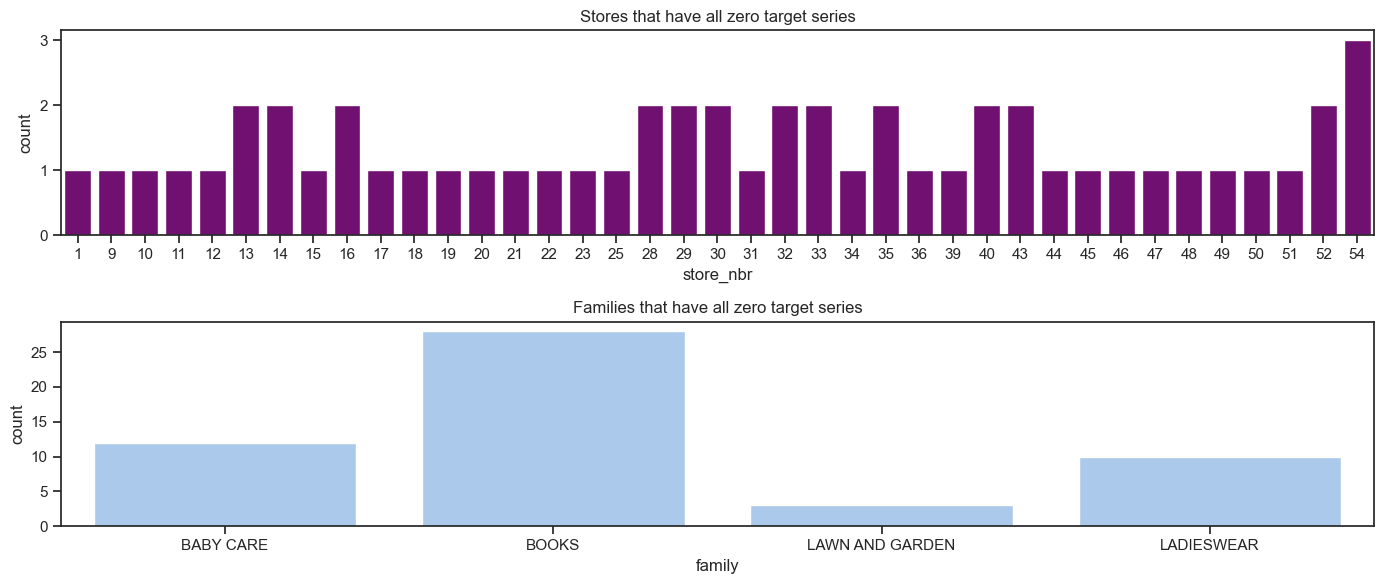

In [ ]:
all_zero_pairs = all_zeros.columns.to_frame().reset_index(drop=True).drop(columns=0)
fig = plt.figure(figsize=(14, 6))

ax0=sns.countplot( data=all_zero_pairs, x="store_nbr",color="purple", ax=fig.add_subplot(211))
plt.title("Stores that have all zero target series")

ax0=sns.countplot( data=all_zero_pairs, x="family", ax=fig.add_subplot(212))
plt.title("Families that have all zero target series")

plt.tight_layout()
plt.show()

conclusion: uniformly throughout stores, probably some families of products are not being (successfully) sold in some stores

Problem: leading zeros

In [ ]:
def num_leading_zeros(series):
    nz_idx = np.where(series != 0)[0] # bc it returns a tuple
    if len(nz_idx) == 0:
        # all zeros
        return len(series)
    else:
        return nz_idx[0]
    
# for all pairs store-family number of leading zeros
leading_zeros = df_train_wide.apply(num_leading_zeros).to_frame("num_leading_zeros").reset_index()
# removing all zeros series
leading_zeros = leading_zeros[leading_zeros["num_leading_zeros"] != df_train_wide.shape[0]]

In [ ]:
leading_zeros.head()

level_0  store_nbr        family  num_leading_zeros
0   sales          1    AUTOMOTIVE                  1
2   sales          1        BEAUTY                  1
3   sales          1     BEVERAGES                  1
4   sales          1         BOOKS               1378
5   sales          1  BREAD/BAKERY                  1

Is this more store or family related?

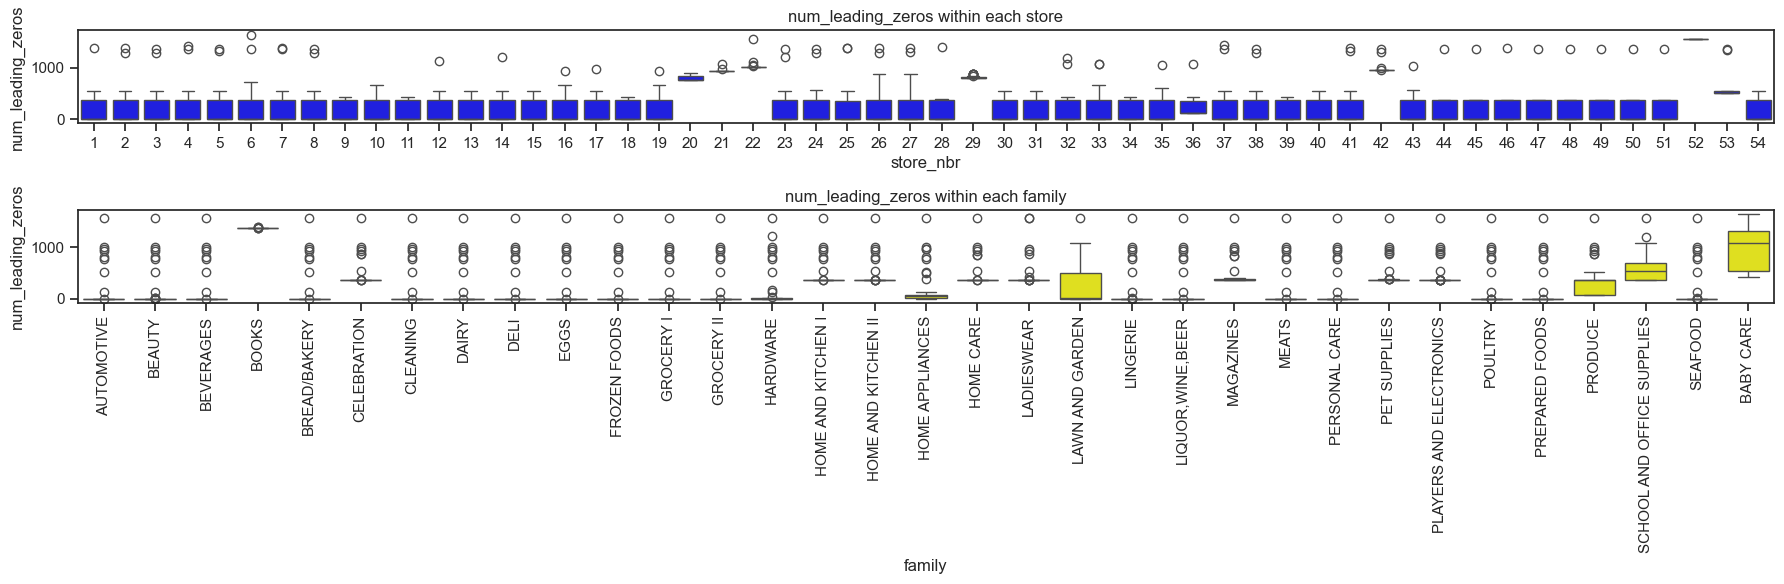

In [ ]:
plot_zeros(leading_zeros, "num_leading_zeros")

conclusion: same conclusion as all zeros conclusion 

Problem: trailing zeros

In [ ]:
def num_trailing_zeros(series):
    nz_idx = np.where(series != 0)[0] # bc it returns a tuple
    if len(nz_idx) == 0:
        # all zeros
        return len(series)
    else:
        return len(series) - nz_idx[-1] - 1
    
# for all pairs store-family number of trailing zeros
trailing_zeros = df_train_wide.apply(num_trailing_zeros).to_frame("num_trailing_zeros").reset_index()
# removing all zeros series
trailing_zeros = trailing_zeros[trailing_zeros["num_trailing_zeros"] != df_train_wide.shape[0]]

In [ ]:
trailing_zeros.head()

level_0  store_nbr        family  num_trailing_zeros
0   sales          1    AUTOMOTIVE                   0
2   sales          1        BEAUTY                   0
3   sales          1     BEVERAGES                   0
4   sales          1         BOOKS                  15
5   sales          1  BREAD/BAKERY                   0

Is this more store or family related?

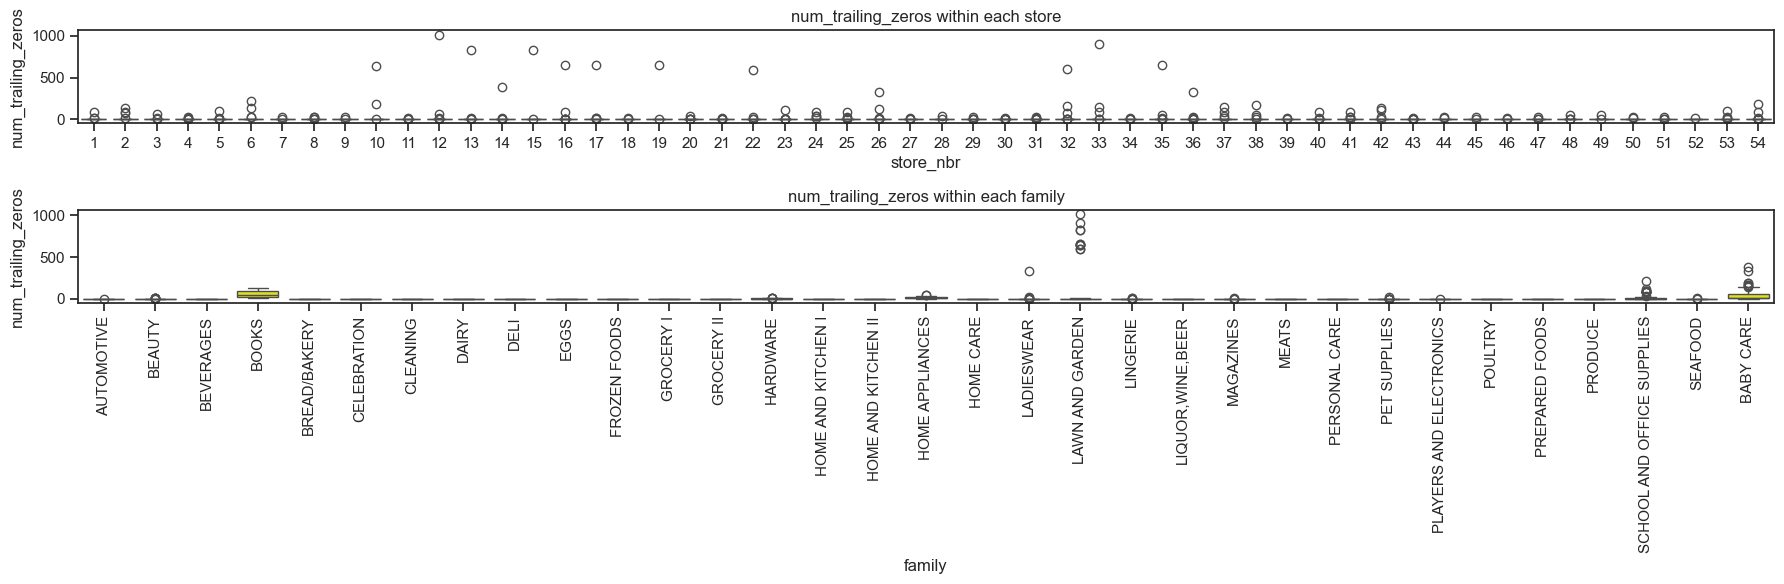

In [ ]:
plot_zeros(trailing_zeros, "num_trailing_zeros")

conclusion: "poor sales performance or that the product is no longer available towards the end. An example would be lawn and garden. In this case, generating zero forecasts for such target series would be a reasonable approach."

## Correlations

In [ ]:
scaler=MinMaxScaler()

train_wide_scaled = df_train_wide.copy()
for col in train_wide_scaled.columns:
    train_wide_scaled[col] = scaler.fit_transform(train_wide_scaled[[col]])

train_wide_scaled.head()

sales                                                   \
store_nbr          1                                                     
family     AUTOMOTIVE BABY CARE    BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                     
2013-01-01   0.000000       0.0  0.000000  0.000000   0.0     0.000000   
2013-01-02   0.105263       0.0  0.166667  0.215997   0.0     0.631313   
2013-01-03   0.157895       0.0  0.000000  0.181944   0.0     0.416700   
2013-01-04   0.157895       0.0  0.250000  0.188676   0.0     0.266080   
2013-01-05   0.263158       0.0  0.250000  0.229657   0.0     0.403825   

                                                                             \
store_nbr                                                                     
family     CELEBRATION  CLEANING     DAIRY      DELI      EGGS FROZEN FOODS   
date                                                                          
2013-01-01         0.0  0.000000  0.000000  0.000000  0.000000     0.000000   
2013-01-02         0.0  0.638939  0.472653  0.608908  1.000000     0.023356   
2013-01-03         0.0  0.503918  0.369796  0.562565  0.825203     0.015519   
2013-01-04         0.0  0.498493  0.375510  0.487704  0.695122     0.011589   
2013-01-05         0.0  0.488849  0.378776  0.440207  0.719512     0.012481   

                                                              \
store_nbr                                                      
family     GROCERY I GROCERY II  HARDWARE HOME AND KITCHEN I   
date                                                           
2013-01-01  0.000000   0.000000  0.000000                0.0   
2013-01-02  0.292554   0.206667  0.230769                0.0   
2013-01-03  0.233977   0.080000  0.076923                0.0   
2013-01-04  0.226806   0.100000  0.538462                0.0   
2013-01-05  0.244457   0.200000  0.076923                0.0   

                                                                     \
store_nbr                                                             
family     HOME AND KITCHEN II HOME APPLIANCES HOME CARE LADIESWEAR   
date                                                                  
2013-01-01                 0.0        0.000000       0.0        0.0   
2013-01-02                 0.0        0.000000       0.0        0.0   
2013-01-03                 0.0        0.333333       0.0        0.0   
2013-01-04                 0.0        0.000000       0.0        0.0   
2013-01-05                 0.0        0.000000       0.0        0.0   

                                                                           \
store_nbr                                                                   
family     LAWN AND GARDEN  LINGERIE LIQUOR,WINE,BEER MAGAZINES     MEATS   
date                                                                        
2013-01-01        0.000000  0.000000         0.000000       0.0  0.000000   
2013-01-02        0.095238  0.276596         0.112605       0.0  0.329662   
2013-01-03        0.000000  0.319149         0.110924       0.0  0.243221   
2013-01-04        0.066667  0.510638         0.171429       0.0  0.405643   
2013-01-05        0.095238  0.425532         0.267227       0.0  0.293792   

                                                                         \
store_nbr                                                                 
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   POULTRY   
date                                                                      
2013-01-01      0.000000          0.0                     0.0  0.000000   
2013-01-02      0.243108          0.0                     0.0  0.277302   
2013-01-03      0.191729          0.0                     0.0  0.210000   
2013-01-04      0.110276          0.0                     0.0  0.289329   
2013-01-05      0.176692          0.0                     0.0  0.238095   

                                                  

In [ ]:
# convert back to long form
df_sales_scaled = train_wide_scaled.melt(value_name='sales_scaled', ignore_index=False).reset_index()
df_sales_scaled_sorted = df_sales_scaled.sort_values(by=['date', 'store_nbr','family'])
df_sales_scaled_sorted = df_sales_scaled_sorted.reset_index(drop=True)
df_sales_scaled_sorted.tail()

date   None  store_nbr                      family  sales_scaled
3000883 2017-08-15  sales         54                     POULTRY      0.168551
3000884 2017-08-15  sales         54              PREPARED FOODS      0.525140
3000885 2017-08-15  sales         54                     PRODUCE      0.540480
3000886 2017-08-15  sales         54  SCHOOL AND OFFICE SUPPLIES      0.000000
3000887 2017-08-15  sales         54                     SEAFOOD      0.125000

### Onpromotion

In [ ]:
train_prom = df_train.copy()

#wide format
train_prom_wide = pd.pivot(train_prom, index='date', columns=['store_nbr','family'], values='onpromotion')

#scaling promotion for
train_prom_wide_scaled = train_prom_wide.copy()
for col in train_prom_wide_scaled.columns:
    train_prom_wide_scaled[col] = scaler.fit_transform(train_prom_wide_scaled[[col]])

train_prom_wide_scaled.sample()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2015-06-14        0.0       0.0    0.0       0.0   0.0          0.0   

store_nbr                                                              \
family     CELEBRATION CLEANING     DAIRY DELI      EGGS FROZEN FOODS   
date                                                                    
2015-06-14         0.0      0.0  0.040816  0.0  0.032258          0.0   

store_nbr                                                    \
family     GROCERY I GROCERY II HARDWARE HOME AND KITCHEN I   
date                                                          
2015-06-14  0.011976        0.0      0.0                0.0   

store_nbr                                                            \
family     HOME AND KITCHEN II HOME APPLIANCES HOME CARE LADIESWEAR   
date                                                                  
2015-06-14                 0.0             0.0       0.0        0.0   

store_nbr                                                                 \
family     LAWN AND GARDEN LINGERIE LIQUOR,WINE,BEER MAGAZINES     MEATS   
date                                                                       
2015-06-14             0.0      0.0              0.0       0.0  0.019231   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2015-06-14           0.0          0.0                     0.0     0.0   

store_nbr                                                             \
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD   
date                                                                   
2015-06-14            0.0     0.0                        0.0     0.0   

store_nbr          10                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2015-06-14        0.0       0.0    0.0  0.112903   0.0     0.857143   

store_nbr                                                                   \
family     CELEBRATION CLEANING     DAIRY DELI EGGS FROZEN FOODS GROCERY I   
date                                                                         
2015-06-14         0.0      0.0  0.012048  0.0  0.0     0.095238   0.01626   

store_nbr                                                              \
family     GROCERY II HARDWARE HOME AND KITCHEN I HOME AND KITCHEN II   
date                                                                    
2015-06-14        0.0      0.0                0.0                 0.0   

store_nbr                                                                 \
family     HOME APPLIANCES HOME CARE LADIESWEAR LAWN AND GARDEN LINGERIE   
date                                                                       
2015-06-14             0.0       0.0        0.0             0.0      0.0   

store_nbr                                                               \
family     LIQUOR,WINE,BEER MAGAZINES MEATS PERSONAL CARE PET SUPPLIES   
date                                                                     
2015-06-14              0.0       0.0   0.0           0.0          0.0   

store_nbr                                                          \
family     PLAYERS AND ELECTRONICS POULTRY PREPARED FOODS PRODUCE   
date                                                                
2015-06-14                     0.0     0.0            0.0     0.0   

store_nbr                                             11                   \
family     SCHOOL AND OFFICE SUPPLIES SEAFOOD AUTOMOTIVE BABY CARE BEAUTY   
date                                                                     

Correlation between prom_scaled and sales_scaled: 0.30114940024437264


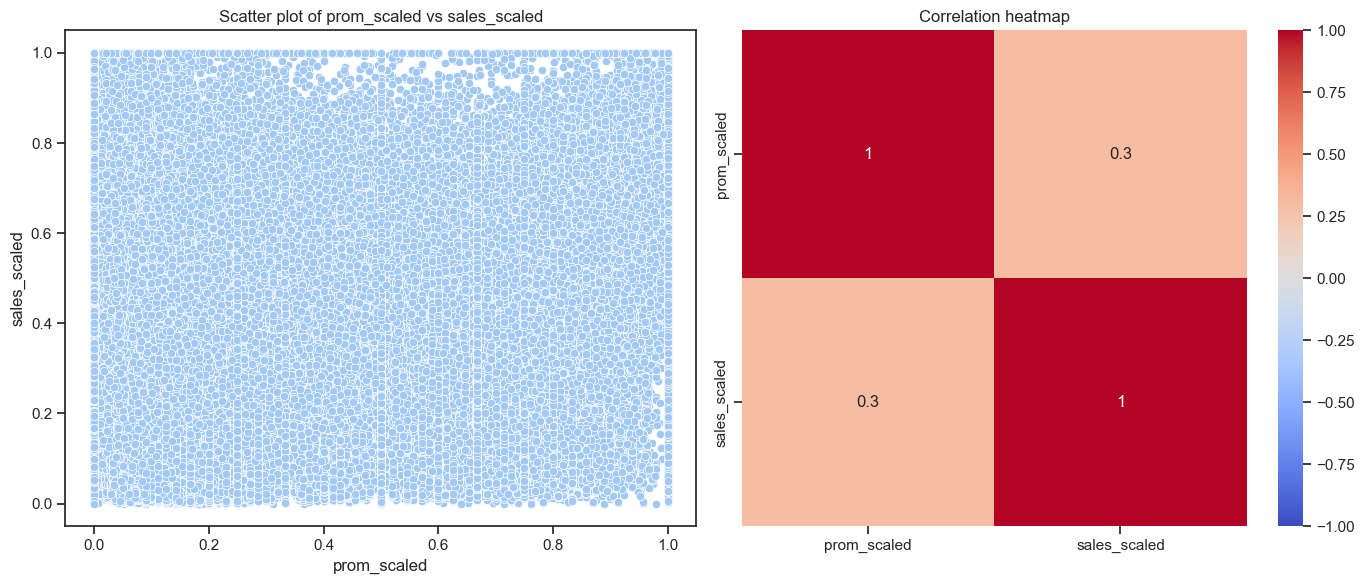

In [ ]:
# convert back to long form

df_prom_scaled = train_prom_wide_scaled.melt(value_name='prom_scaled', ignore_index=False).reset_index()
df_prom_scaled_sorted = df_prom_scaled.sort_values(by=['date', 'store_nbr' ,'family'])
df_prom_scaled_sorted = df_prom_scaled_sorted.reset_index(drop=True)

# adding sales_scaled column to train_prom
train_prom.loc[:,'sales_scaled'] = df_sales_scaled_sorted.loc[:,'sales_scaled'].copy()
train_prom.loc[:,'prom_scaled'] = df_prom_scaled_sorted.loc[:,'prom_scaled'].copy()

plot_correlation(train_prom['prom_scaled'], train_prom['sales_scaled'])

checking promotion correlation with different families

In [ ]:
family_promo_corr = pd.Series(
    {fam: train_prom[train_prom['family'] == fam]['prom_scaled'].corr(train_prom[train_prom['family'] == fam]['sales_scaled'])
     for fam in df_train['family'].unique()}
)

family_promo_corr.sort_values(ascending=False)
# BOOKS are never on promotion

SCHOOL AND OFFICE SUPPLIES    0.588960
PRODUCE                       0.448216
BEVERAGES                     0.442064
HOME CARE                     0.411711
BEAUTY                        0.328253
DAIRY                         0.304040
MEATS                         0.295704
HOME AND KITCHEN I            0.294272
SEAFOOD                       0.269534
GROCERY I                     0.260793
PET SUPPLIES                  0.246390
BREAD/BAKERY                  0.245726
HOME AND KITCHEN II           0.234865
LAWN AND GARDEN               0.232771
FROZEN FOODS                  0.218614
PERSONAL CARE                 0.206704
POULTRY                       0.199801
LIQUOR,WINE,BEER              0.198268
DELI                          0.180141
CLEANING                      0.135449
AUTOMOTIVE                    0.127871
PREPARED FOODS                0.127793
EGGS                          0.120620
CELEBRATION                   0.116698
GROCERY II                    0.090691
PLAYERS AND ELECTRONICS  

In [ ]:
# mean sales and mean promotion
mean_train_wide_scaled = train_wide_scaled.mean(axis=1).to_frame("sales").reset_index()
mean_train_prom_wide_scaled = train_prom_wide_scaled.mean(axis=1).to_frame("onpromotion").reset_index()

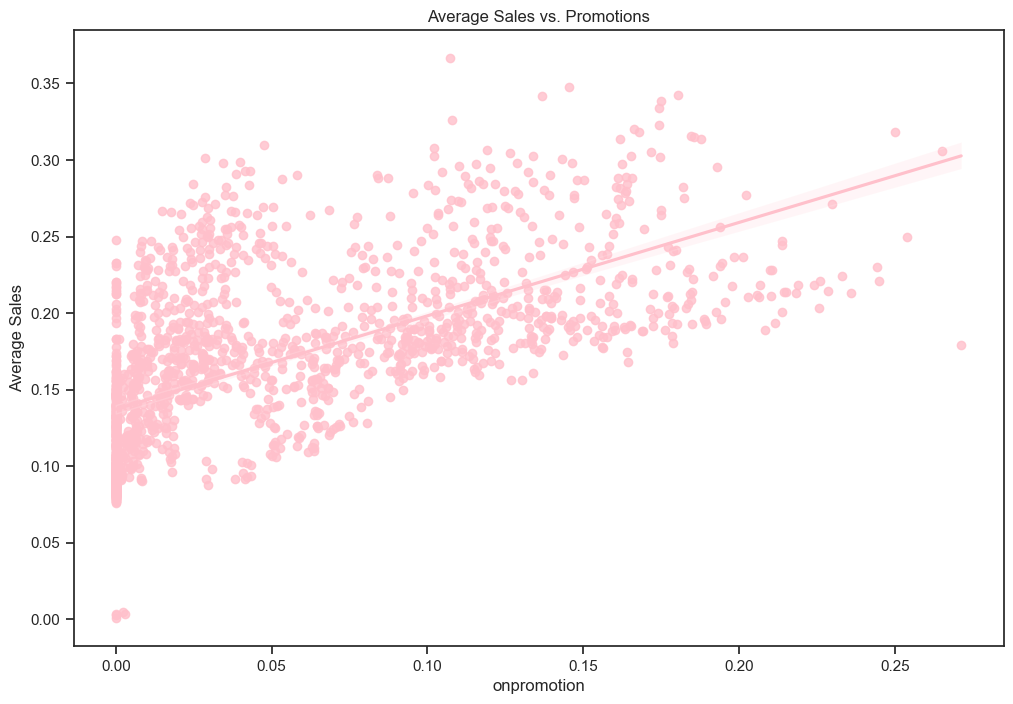

In [ ]:
# plot mean sales mean promotion
# every point is one date
fig = plt.figure(figsize=(12, 8))
sns.regplot(x=mean_train_prom_wide_scaled.onpromotion, y=mean_train_wide_scaled.sales, color='pink')
plt.xlabel("onpromotion")
plt.ylabel("Average Sales")
plt.title("Average Sales vs. Promotions")

plt.show()

conclusion: promotions are positively corr with avg sales

# Preprocessing

In [ ]:
train = pd.read_csv("originalni_datasetovi/train.csv", parse_dates=['date'])
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None


id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

In [ ]:
test = pd.read_csv("originalni_datasetovi/test.csv", parse_dates=['date'])
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB
None


id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [ ]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())

NO_FAMILIES = train.family.nunique()
NO_STORES = train.store_nbr.nunique()

0
0


In [ ]:
# Missing dates

# number of days that should be in train set
date_min_train = train.date.min()
date_max_train = train.date.max()
nbr_days_train = (date_max_train-date_min_train).days+1
print("Number of days that should be in train set: ",nbr_days_train)
print("Number of days that are in train: ", train.date.nunique())

# number of days that should be in test set
date_min_test = test.date.min()
date_max_test = test.date.max()
nbr_days_test = (date_max_test-date_min_test).days+1
print("Number of days that should be in test set: ",nbr_days_test)
print("Number of days that are in test: ", test.date.nunique())

Number of days that should be in train set:  1688
Number of days that are in train:  1684
Number of days that should be in test set:  16
Number of days that are in test:  16


In [ ]:
# there are 4 missing dates in train set

missing_dates = pd.date_range(date_min_train, date_max_train).difference(train.date.unique())
missing_dates

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

In [ ]:
# cheching is there any other date that is missing data for some stores
nbr_stores = 54
nbr_families=33
# number of rows that train should have
print("number of rows that train should have: ",nbr_days_train*nbr_stores*nbr_families)
print("number of rows train has: ", train.shape[0])
print("number of rows train will have after adding christmas: ", train.shape[0]+4*nbr_families*nbr_stores)

number of rows that train should have:  3008016
number of rows train has:  3000888
number of rows train will have after adding christmas:  3008016


In [ ]:
# adding missing dates

new_index = pd.MultiIndex.from_product([pd.date_range(date_min_train, date_max_train), train.store_nbr.unique(), train.family.unique()],names=['date', 'store_nbr', 'family'])
train = train.set_index(['date','store_nbr','family'])
train = train.reindex(new_index).reset_index()
print("Number of days that are in train: ", train.date.nunique())

Number of days that are in train:  1688


In [ ]:
train.isna().sum()

date              0
store_nbr         0
family            0
id             7128
sales          7128
onpromotion    7128
dtype: int64

In [ ]:
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.)

In [ ]:
train.isna().sum()

date              0
store_nbr         0
family            0
id             7128
sales             0
onpromotion       0
dtype: int64

### Holiday

In [ ]:
holidays = pd.read_csv("originalni_datasetovi/holidays_events.csv", parse_dates=['date'])
#TYPE: transferred - not actually celebrated on that day

transferred_holidays = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True) #holidays that were transferred
transfer = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True) #days that they were transferred to (in ds they are always below the actual holiday so indexes are going to match)
tr = pd.concat([transferred_holidays,transfer], axis = 1) 
tr = tr.iloc[:, [5,1,2,3,4]] #getting rid of dupplicate columns, keeping date from transferred, everything else from transferred_holidays
tr

date     type    locale locale_name                    description
0  2012-10-12  Holiday  National     Ecuador     Independencia de Guayaquil
1  2013-10-11  Holiday  National     Ecuador     Independencia de Guayaquil
2  2014-10-10  Holiday  National     Ecuador     Independencia de Guayaquil
3  2016-05-27  Holiday  National     Ecuador           Batalla de Pichincha
4  2016-07-24  Holiday     Local   Guayaquil         Fundacion de Guayaquil
5  2016-08-12  Holiday  National     Ecuador  Primer Grito de Independencia
6  2017-01-02  Holiday  National     Ecuador             Primer dia del ano
7  2017-04-13  Holiday     Local      Cuenca            Fundacion de Cuenca
8  2017-05-26  Holiday  National     Ecuador           Batalla de Pichincha
9  2017-08-11  Holiday  National     Ecuador  Primer Grito de Independencia
10 2017-09-29  Holiday     Local      Ibarra            Fundacion de Ibarra
11 2017-12-08  Holiday     Local       Quito             Fundacion de Quito

We changed transferred holidays dates to their actual celebrated dates and deleted transfer holidays 

In [ ]:
#deleting transferred holidays and transfer days from holidays and we don't need transferred column anymore
holidays = holidays[(holidays.transferred==False) & (holidays.type !='Transfer')].drop('transferred',axis=1)

#adding concated transferred holidays and transfer days
holidays = pd.concat([holidays,tr]).reset_index(drop=True)

holidays.head()

date     type    locale locale_name                    description
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba

In [ ]:
# TYPE: Additional 
# have the same name as regular holiday but with + or - number 
# removing +-number

def clean_description(desc):
    desc = re.sub(r'[+-]', '', desc)  # Remove + and -
    desc = re.sub(r'\d+', '', desc)  # Remove digits
    return desc

holidays["description"] = holidays["description"].apply(clean_description)

# TYPE: Bridge
# have the same name as regular holiday but with Puente at the beginning
# removing puente

holidays["description"] = holidays["description"].str.replace("Puente ", "")

In [ ]:
# TYPE: Work Day
# work days are not actually holidays, they are just days that you wouldn't regularly work on but now you do (saturdays)
# removing them

work_days = holidays[holidays['type'] == 'Work Day']
holidays = holidays[holidays['type'] != 'Work Day']

# TYPE: Event
# "There are many football events referred to by the match name that include the word 'futbal'

holidays.loc[holidays["description"].str.contains("futbol"), "description"] = "Futbol"

In [ ]:
# Splitting by locale

# Local holidays - city level
local_holidays=holidays[holidays['locale']=='Local']
local_holidays=local_holidays.rename(columns={'locale_name':'city','description': 'local_holidays'})
local_holidays=local_holidays.reset_index(drop=True)
local_holidays.drop(columns=['locale','type'],inplace=True)
local_holidays = local_holidays.drop_duplicates()
local_holidays['local_holidays'] = local_holidays['local_holidays'].apply(lambda x: 'L ' + x)

# Regional holidays
regional_holidays=holidays[holidays['locale']=='Regional']
regional_holidays=regional_holidays.rename(columns={'locale_name':'state', 'description':'regional_holidays'})
regional_holidays=regional_holidays.reset_index(drop=True)
regional_holidays.drop(columns=['locale','type'],inplace=True)
regional_holidays = regional_holidays.drop_duplicates()
regional_holidays['regional_holidays'] = regional_holidays['regional_holidays'].apply(lambda x: 'R ' + x)

# National holidays and events
national_holidays=holidays[holidays['locale']=='National']
national_holidays=national_holidays.rename(columns={'description':'national_holidays'})
national_holidays=national_holidays.reset_index(drop=True)
national_holidays.drop(columns=['locale','type','locale_name'],inplace=True)
national_holidays = national_holidays.drop_duplicates()
national_holidays['national_holidays'] = national_holidays['national_holidays'].apply(lambda x: 'N ' + x)

### Oil

In [ ]:
oil = pd.read_csv("originalni_datasetovi/oil.csv", parse_dates=['date'])
oil = oil.rename(columns={'dcoilwtico':'oil_price'})
oil.head()

date  oil_price
0 2013-01-01        NaN
1 2013-01-02      93.14
2 2013-01-03      92.97
3 2013-01-04      93.12
4 2013-01-07      93.20

In [ ]:
#Missing dates

#number of days that should be in oil set
date_min_oil = oil.date.min()
date_max_oil = oil.date.max()
nbr_days_oil = (date_max_oil-date_min_oil).days+1
print("Number of days that should be in oil set: ",nbr_days_oil)
print("Number of days that are in oil: ", oil.date.nunique())

Number of days that should be in oil set:  1704
Number of days that are in oil:  1218


In [ ]:
# checking for missing dates in dataset
missing_oil_dates=pd.date_range(date_min_train, date_max_test).difference(oil.date)
missing_oil_days=[]
for date in missing_oil_dates:
    day_name = datetime.date.strftime(date, '%A')
    missing_oil_days.append(day_name)

print(set(missing_oil_days)) 

{'Saturday', 'Sunday'}


In [ ]:
# adding missing dates

new_index_oil = pd.date_range(date_min_oil, date_max_oil)
oil = oil.set_index(['date'])
oil = oil.reindex(new_index_oil).reset_index()

#filling missing values with lin interpolation
oil['oil_price'] = oil['oil_price'].interpolate(method='linear', limit_direction='both')
oil.head()

index  oil_price
0 2013-01-01  93.140000
1 2013-01-02  93.140000
2 2013-01-03  92.970000
3 2013-01-04  93.120000
4 2013-01-05  93.146667

### Transactions

In [ ]:
transactions=pd.read_csv("originalni_datasetovi/transactions.csv", parse_dates=['date'])
transactions.head()

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

In [ ]:
# Missing dates

# number of days that should be in transactions set
date_min_trans=transactions.date.min()
date_max_trans=transactions.date.max()
nbr_days_trans=(date_max_trans-date_min_trans).days+1
print("Number of days that should be in transactions set: ",nbr_days_trans)
print("Number of days that are in transactions: ", transactions.date.nunique())

Number of days that should be in transactions set:  1688
Number of days that are in transactions:  1682


In [ ]:
missing_dates_trans = pd.date_range(date_min_trans, date_max_trans).difference(transactions.date)
missing_dates_trans

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-01-01',
               '2016-01-03', '2016-12-25'],
              dtype='datetime64[ns]', freq=None)

there are missing entries for some stores

In [ ]:
print("number of rows that transactions should have: ",nbr_stores*nbr_days_train)
print("number of rows transactions have ",transactions.shape[0])

number of rows that transactions should have:  91152
number of rows transactions have  83488


adding 0s for transactions where sum of sales for that store is 0

In [ ]:
# sum od sales by date and store
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()
transactions = transactions.merge(store_sales,on=["date", "store_nbr"], how="outer",).sort_values(["date", "store_nbr"], ignore_index=True)

transactions.loc[transactions.sales.eq(0), "transactions"] = 0.
transactions = transactions.drop(columns=["sales"])

In [ ]:
print("number of rows transactions have ",transactions.shape[0])

number of rows transactions have  91152


In [ ]:
# checking for NaN values beside that
transactions.isna().sum()

date              0
store_nbr         0
transactions    118
dtype: int64

filling missing values that are not caused bu 0 sales with lin int

In [ ]:
transactions.transactions = transactions.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both"))

In [ ]:
transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

### Data concatenation

In [ ]:
# temp putting NaN for every 1.1.
train.loc[(train['date'].dt.month == 1) & (train['date'].dt.day == 1) & (train['sales']==0), ['sales', 'onpromotion']] = np.nan
train.loc[(train['date'].dt.month == 12) & (train['date'].dt.day == 25) & (train['sales']==0), ['sales', 'onpromotion']] = np.nan

In [ ]:
# concatenating train and test
data = pd.concat([train, test], axis=0, ignore_index=True,)

# concatenating transactions with data
data = data.merge(transactions, on=["date", "store_nbr"], how="left")

# concatenating oil with data
oil = oil.rename(columns={'index':'date'})
data = data.merge(oil, on="date", how="left")

In [ ]:
data.head()

date  store_nbr      family   id  sales  onpromotion  transactions  \
0 2013-01-01          1  AUTOMOTIVE  0.0    NaN          NaN           0.0   
1 2013-01-01          1   BABY CARE  1.0    NaN          NaN           0.0   
2 2013-01-01          1      BEAUTY  2.0    NaN          NaN           0.0   
3 2013-01-01          1   BEVERAGES  3.0    NaN          NaN           0.0   
4 2013-01-01          1       BOOKS  4.0    NaN          NaN           0.0   

   oil_price  
0      93.14  
1      93.14  
2      93.14  
3      93.14  
4      93.14

In [ ]:
# concatenating work days with data
work_days = work_days[['date','type']].rename(columns={'type':'work_day'}).reset_index(drop=True)
work_days.work_day = work_days.work_day.notna().astype(int)
df = pd.merge(data,work_days, how='left', on='date')
df['work_day'] = df['work_day'].fillna(0).astype(int)
df.head()

date  store_nbr      family   id  sales  onpromotion  transactions  \
0 2013-01-01          1  AUTOMOTIVE  0.0    NaN          NaN           0.0   
1 2013-01-01          1   BABY CARE  1.0    NaN          NaN           0.0   
2 2013-01-01          1      BEAUTY  2.0    NaN          NaN           0.0   
3 2013-01-01          1   BEVERAGES  3.0    NaN          NaN           0.0   
4 2013-01-01          1       BOOKS  4.0    NaN          NaN           0.0   

   oil_price  work_day  
0      93.14         0  
1      93.14         0  
2      93.14         0  
3      93.14         0  
4      93.14         0

In [ ]:
#local holidays
#there could be multiple holidays on the same day so one hot encoding doesn't work
local_holidays_wide = local_holidays.pivot_table(index='date', columns='local_holidays', aggfunc='size', fill_value=0)
local_holidays_wide = local_holidays_wide.astype(int)
local_holidays_wide = local_holidays_wide.reset_index() #to return date as a column
df=pd.merge(df,local_holidays_wide, how='left', on=['date'])
for col in local_holidays_wide.columns:
    if col != 'date':
        df[col] = df[col].fillna(0).astype(int)
df.head()

date  store_nbr      family   id  sales  onpromotion  transactions  \
0 2013-01-01          1  AUTOMOTIVE  0.0    NaN          NaN           0.0   
1 2013-01-01          1   BABY CARE  1.0    NaN          NaN           0.0   
2 2013-01-01          1      BEAUTY  2.0    NaN          NaN           0.0   
3 2013-01-01          1   BEVERAGES  3.0    NaN          NaN           0.0   
4 2013-01-01          1       BOOKS  4.0    NaN          NaN           0.0   

   oil_price  work_day  L Cantonizacion de Cayambe  \
0      93.14         0                           0   
1      93.14         0                           0   
2      93.14         0                           0   
3      93.14         0                           0   
4      93.14         0                           0   

   L Cantonizacion de El Carmen  L Cantonizacion de Guaranda  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   L Cantonizacion de Latacunga  L Cantonizacion de Libertad  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   L Cantonizacion de Quevedo  L Cantonizacion de Riobamba  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   L Cantonizacion de Salinas  L Cantonizacion del Puyo  \
0                           0                         0   
1                           0                         0   
2                           0                         0   
3                           0                         0   
4                           0                         0   

   L Fundacion de Ambato  L Fundacion de Cuenca  L Fundacion de Esmeraldas  \
0                      0                      0                          0   
1                      0                      0                          0   
2                      0                      0                          0   
3                      0                      0                          0   
4                      0                      0                          0   

   L Fundacion de Guayaquil  L Fundacion de Ibarra  L Fundacion de Loja  \
0                         0                      0                    0   
1                         0                      0                    0   
2                         0                      0                    0   
3                         0                      0                    0   
4                         0                      0                    0   

   L Fundacion de Machala  L Fundacion de Manta  L Fundacion de Quito  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   

   L Fundacion de Riobamba  L Fundacion de Santo Domingo  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0 

In [ ]:
#regional holidays
regional_holidays_wide = regional_holidays.pivot_table(index='date', columns='regional_holidays', aggfunc='size', fill_value=0)
regional_holidays_wide = regional_holidays_wide.astype(int)
regional_holidays_wide = regional_holidays_wide.reset_index() #to return date as a column
df=pd.merge(df,regional_holidays_wide, how='left', on=['date'])
for col in regional_holidays_wide.columns:
    if col != 'date':
        df[col] = df[col].fillna(0).astype(int)
df.head()

date  store_nbr      family   id  sales  onpromotion  transactions  \
0 2013-01-01          1  AUTOMOTIVE  0.0    NaN          NaN           0.0   
1 2013-01-01          1   BABY CARE  1.0    NaN          NaN           0.0   
2 2013-01-01          1      BEAUTY  2.0    NaN          NaN           0.0   
3 2013-01-01          1   BEVERAGES  3.0    NaN          NaN           0.0   
4 2013-01-01          1       BOOKS  4.0    NaN          NaN           0.0   

   oil_price  work_day  L Cantonizacion de Cayambe  \
0      93.14         0                           0   
1      93.14         0                           0   
2      93.14         0                           0   
3      93.14         0                           0   
4      93.14         0                           0   

   L Cantonizacion de El Carmen  L Cantonizacion de Guaranda  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   L Cantonizacion de Latacunga  L Cantonizacion de Libertad  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   L Cantonizacion de Quevedo  L Cantonizacion de Riobamba  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   L Cantonizacion de Salinas  L Cantonizacion del Puyo  \
0                           0                         0   
1                           0                         0   
2                           0                         0   
3                           0                         0   
4                           0                         0   

   L Fundacion de Ambato  L Fundacion de Cuenca  L Fundacion de Esmeraldas  \
0                      0                      0                          0   
1                      0                      0                          0   
2                      0                      0                          0   
3                      0                      0                          0   
4                      0                      0                          0   

   L Fundacion de Guayaquil  L Fundacion de Ibarra  L Fundacion de Loja  \
0                         0                      0                    0   
1                         0                      0                    0   
2                         0                      0                    0   
3                         0                      0                    0   
4                         0                      0                    0   

   L Fundacion de Machala  L Fundacion de Manta  L Fundacion de Quito  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   

   L Fundacion de Riobamba  L Fundacion de Santo Domingo  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0 

In [ ]:
#national holidays
national_holidays_wide = national_holidays.pivot_table(index='date', columns='national_holidays', aggfunc='size', fill_value=0)
national_holidays_wide = national_holidays_wide.astype(int)
national_holidays_wide = national_holidays_wide.reset_index() #to return date as a column
df=pd.merge(df,national_holidays_wide, how='left', on=['date'])
for col in national_holidays_wide.columns:
    if col != 'date':
        df[col] = df[col].fillna(0).astype(int)
df.head()

date  store_nbr      family   id  sales  onpromotion  transactions  \
0 2013-01-01          1  AUTOMOTIVE  0.0    NaN          NaN           0.0   
1 2013-01-01          1   BABY CARE  1.0    NaN          NaN           0.0   
2 2013-01-01          1      BEAUTY  2.0    NaN          NaN           0.0   
3 2013-01-01          1   BEVERAGES  3.0    NaN          NaN           0.0   
4 2013-01-01          1       BOOKS  4.0    NaN          NaN           0.0   

   oil_price  work_day  L Cantonizacion de Cayambe  \
0      93.14         0                           0   
1      93.14         0                           0   
2      93.14         0                           0   
3      93.14         0                           0   
4      93.14         0                           0   

   L Cantonizacion de El Carmen  L Cantonizacion de Guaranda  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   L Cantonizacion de Latacunga  L Cantonizacion de Libertad  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   L Cantonizacion de Quevedo  L Cantonizacion de Riobamba  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   L Cantonizacion de Salinas  L Cantonizacion del Puyo  \
0                           0                         0   
1                           0                         0   
2                           0                         0   
3                           0                         0   
4                           0                         0   

   L Fundacion de Ambato  L Fundacion de Cuenca  L Fundacion de Esmeraldas  \
0                      0                      0                          0   
1                      0                      0                          0   
2                      0                      0                          0   
3                      0                      0                          0   
4                      0                      0                          0   

   L Fundacion de Guayaquil  L Fundacion de Ibarra  L Fundacion de Loja  \
0                         0                      0                    0   
1                         0                      0                    0   
2                         0                      0                    0   
3                         0                      0                    0   
4                         0                      0                    0   

   L Fundacion de Machala  L Fundacion de Manta  L Fundacion de Quito  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   

   L Fundacion de Riobamba  L Fundacion de Santo Domingo  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0 

In [ ]:
stores=pd.read_csv(r'originalni_datasetovi\stores.csv')
#Adding stores data
df=pd.merge(df,stores)
df.head()

date  store_nbr      family   id  sales  onpromotion  transactions  \
0 2013-01-01          1  AUTOMOTIVE  0.0    NaN          NaN           0.0   
1 2013-01-01          1   BABY CARE  1.0    NaN          NaN           0.0   
2 2013-01-01          1      BEAUTY  2.0    NaN          NaN           0.0   
3 2013-01-01          1   BEVERAGES  3.0    NaN          NaN           0.0   
4 2013-01-01          1       BOOKS  4.0    NaN          NaN           0.0   

   oil_price  work_day  L Cantonizacion de Cayambe  \
0      93.14         0                           0   
1      93.14         0                           0   
2      93.14         0                           0   
3      93.14         0                           0   
4      93.14         0                           0   

   L Cantonizacion de El Carmen  L Cantonizacion de Guaranda  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   L Cantonizacion de Latacunga  L Cantonizacion de Libertad  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   L Cantonizacion de Quevedo  L Cantonizacion de Riobamba  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   L Cantonizacion de Salinas  L Cantonizacion del Puyo  \
0                           0                         0   
1                           0                         0   
2                           0                         0   
3                           0                         0   
4                           0                         0   

   L Fundacion de Ambato  L Fundacion de Cuenca  L Fundacion de Esmeraldas  \
0                      0                      0                          0   
1                      0                      0                          0   
2                      0                      0                          0   
3                      0                      0                          0   
4                      0                      0                          0   

   L Fundacion de Guayaquil  L Fundacion de Ibarra  L Fundacion de Loja  \
0                         0                      0                    0   
1                         0                      0                    0   
2                         0                      0                    0   
3                         0                      0                    0   
4                         0                      0                    0   

   L Fundacion de Machala  L Fundacion de Manta  L Fundacion de Quito  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   

   L Fundacion de Riobamba  L Fundacion de Santo Domingo  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0 

In [ ]:
df.columns

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'transactions', 'oil_price', 'work_day', 'L Cantonizacion de Cayambe',
       'L Cantonizacion de El Carmen', 'L Cantonizacion de Guaranda',
       'L Cantonizacion de Latacunga', 'L Cantonizacion de Libertad',
       'L Cantonizacion de Quevedo', 'L Cantonizacion de Riobamba',
       'L Cantonizacion de Salinas', 'L Cantonizacion del Puyo',
       'L Fundacion de Ambato', 'L Fundacion de Cuenca',
       'L Fundacion de Esmeraldas', 'L Fundacion de Guayaquil',
       'L Fundacion de Ibarra', 'L Fundacion de Loja',
       'L Fundacion de Machala', 'L Fundacion de Manta',
       'L Fundacion de Quito', 'L Fundacion de Riobamba',
       'L Fundacion de Santo Domingo', 'L Independencia de Ambato',
       'L Independencia de Guaranda', 'L Independencia de Latacunga',
       'R Provincializacion Santa Elena', 'R Provincializacion de Cotopaxi',
       'R Provincializacion de Imbabura',
       'R Provincializacion de Sa

In [ ]:
df.to_csv("after_prep2.csv")

### A/B testing holiday significance

In [ ]:
df = pd.read_csv("originalni_datasetovi/after_prep2.csv", parse_dates=['date'])
local_holidays=pd.read_csv(r'holiday_datasets/local_holidays.csv', parse_dates=['date'])
regional_holidays=pd.read_csv(r'holiday_datasets/regional_holidays.csv',parse_dates=['date'])
national_holidays=pd.read_csv(r'holiday_datasets/national_holidays.csv', parse_dates=['date'])

df = df.drop(columns='Unnamed: 0')
df.head()

date  store_nbr      family   id  sales  onpromotion  transactions  \
0 2013-01-01          1  AUTOMOTIVE  0.0    NaN          NaN           0.0   
1 2013-01-01          1   BABY CARE  1.0    NaN          NaN           0.0   
2 2013-01-01          1      BEAUTY  2.0    NaN          NaN           0.0   
3 2013-01-01          1   BEVERAGES  3.0    NaN          NaN           0.0   
4 2013-01-01          1       BOOKS  4.0    NaN          NaN           0.0   

   oil_price  work_day  L Cantonizacion de Cayambe  \
0      93.14         0                           0   
1      93.14         0                           0   
2      93.14         0                           0   
3      93.14         0                           0   
4      93.14         0                           0   

   L Cantonizacion de El Carmen  L Cantonizacion de Guaranda  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   L Cantonizacion de Latacunga  L Cantonizacion de Libertad  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   L Cantonizacion de Quevedo  L Cantonizacion de Riobamba  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   L Cantonizacion de Salinas  L Cantonizacion del Puyo  \
0                           0                         0   
1                           0                         0   
2                           0                         0   
3                           0                         0   
4                           0                         0   

   L Fundacion de Ambato  L Fundacion de Cuenca  L Fundacion de Esmeraldas  \
0                      0                      0                          0   
1                      0                      0                          0   
2                      0                      0                          0   
3                      0                      0                          0   
4                      0                      0                          0   

   L Fundacion de Guayaquil  L Fundacion de Ibarra  L Fundacion de Loja  \
0                         0                      0                    0   
1                         0                      0                    0   
2                         0                      0                    0   
3                         0                      0                    0   
4                         0                      0                    0   

   L Fundacion de Machala  L Fundacion de Manta  L Fundacion de Quito  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   

   L Fundacion de Riobamba  L Fundacion de Santo Domingo  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0 

In [ ]:
df = df.dropna()
df2 = df.copy()

In [ ]:
local_holidays['name']=local_holidays['local_holidays'].copy()
local_holidays=local_holidays.drop(columns=['local_holidays'])
local_holidays['local_holidays']=1
local_holidays2=local_holidays.copy()
local_holidays=local_holidays.drop(columns=['name'])

regional_holidays['name']=regional_holidays['regional_holidays'].copy()
regional_holidays=regional_holidays.drop(columns=['regional_holidays'])
regional_holidays['regional_holidays']=1
regional_holidays2=regional_holidays.copy()
regional_holidays=regional_holidays.drop(columns=['name'])

national_holidays=national_holidays.drop(columns=['national_holidays'])
national_holidays['national_holidays']=1

local_holidays=local_holidays.drop_duplicates()
regional_holidays=regional_holidays.drop_duplicates()
national_holidays=national_holidays.drop_duplicates()
local_holidays2=local_holidays2.drop_duplicates()
regional_holidays2=regional_holidays2.drop_duplicates()

df2=df2.merge(local_holidays, how='left', on=['date', 'city'])
df2['local_holidays']=df2['local_holidays'].fillna(0)
print(df2.shape)

df2=df2.merge(regional_holidays, how='left', on=['date', 'state'])
df2['regional_holidays']=df2['regional_holidays'].fillna(0)
print(df2.shape)

df2=df2.merge(national_holidays, how='left', on=['date'])
df2['national_holidays']=df2['national_holidays'].fillna(0)
print(df2.shape)

df2['national_holidays'] = df2['national_holidays'].astype(int)
df2['regional_holidays'] = df2['regional_holidays'].astype(int)
df2['local_holidays'] = df2['local_holidays'].astype(int)
print(df2.shape)

df2.head()


(2992125, 56)
(2992125, 57)
(2992125, 58)
(2992125, 58)


date  store_nbr      family      id   sales  onpromotion  \
0 2013-01-02          1  AUTOMOTIVE  1782.0     2.0          0.0   
1 2013-01-02          1   BABY CARE  1783.0     0.0          0.0   
2 2013-01-02          1      BEAUTY  1784.0     2.0          0.0   
3 2013-01-02          1   BEVERAGES  1785.0  1091.0          0.0   
4 2013-01-02          1       BOOKS  1786.0     0.0          0.0   

   transactions  oil_price  work_day  L Cantonizacion de Cayambe  \
0        2111.0      93.14         0                           0   
1        2111.0      93.14         0                           0   
2        2111.0      93.14         0                           0   
3        2111.0      93.14         0                           0   
4        2111.0      93.14         0                           0   

   L Cantonizacion de El Carmen  L Cantonizacion de Guaranda  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   L Cantonizacion de Latacunga  L Cantonizacion de Libertad  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   L Cantonizacion de Quevedo  L Cantonizacion de Riobamba  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   L Cantonizacion de Salinas  L Cantonizacion del Puyo  \
0                           0                         0   
1                           0                         0   
2                           0                         0   
3                           0                         0   
4                           0                         0   

   L Fundacion de Ambato  L Fundacion de Cuenca  L Fundacion de Esmeraldas  \
0                      0                      0                          0   
1                      0                      0                          0   
2                      0                      0                          0   
3                      0                      0                          0   
4                      0                      0                          0   

   L Fundacion de Guayaquil  L Fundacion de Ibarra  L Fundacion de Loja  \
0                         0                      0                    0   
1                         0                      0                    0   
2                         0                      0                    0   
3                         0                      0                    0   
4                         0                      0                    0   

   L Fundacion de Machala  L Fundacion de Manta  L Fundacion de Quito  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   

   L Fundacion de Riobamba  L Fundacion de Santo Domingo  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0       

In [ ]:
train2=df2[df2['date']<'2017-08-16']
test2=df2[df2['date']>= '2017-08-16']

In [ ]:
local_holidays2.head()

date      city                         name  local_holidays
0 2012-03-02     Manta         L Fundacion de Manta               1
1 2012-04-12    Cuenca        L Fundacion de Cuenca               1
2 2012-04-14  Libertad  L Cantonizacion de Libertad               1
3 2012-04-21  Riobamba  L Cantonizacion de Riobamba               1
4 2012-05-12      Puyo     L Cantonizacion del Puyo               1

In [ ]:
cols =train2.columns[train2.columns.str.startswith("L ")].tolist()
ab_loc = []
for i in cols:
    ab_loc.append(AB_test_local_holidays(dataframe=train2, group = i, target = "sales"))
ab_loc = pd.concat(ab_loc)
ab_loc

Feature       p-value         Hypothesis  \
0    L Cantonizacion de Cayambe  5.750790e-01  Fail to Reject H0   
0  L Cantonizacion de El Carmen  6.914252e-01  Fail to Reject H0   
0   L Cantonizacion de Guaranda  2.901734e-01  Fail to Reject H0   
0  L Cantonizacion de Latacunga  9.121931e-01  Fail to Reject H0   
0   L Cantonizacion de Libertad  1.527692e-01  Fail to Reject H0   
0    L Cantonizacion de Quevedo  3.493804e-01  Fail to Reject H0   
0   L Cantonizacion de Riobamba  4.964394e-01  Fail to Reject H0   
0    L Cantonizacion de Salinas           NaN          Reject H0   
0      L Cantonizacion del Puyo  6.436056e-01  Fail to Reject H0   
0         L Fundacion de Ambato  5.892010e-01  Fail to Reject H0   
0         L Fundacion de Cuenca  4.402316e-01  Fail to Reject H0   
0     L Fundacion de Esmeraldas  7.277621e-01  Fail to Reject H0   
0      L Fundacion de Guayaquil  5.206136e-01  Fail to Reject H0   
0         L Fundacion de Ibarra  7.813099e-01  Fail to Reject H0   
0           L Fundacion de Loja  1.415707e-01  Fail to Reject H0   
0        L Fundacion de Machala  6.525505e-01  Fail to Reject H0   
0          L Fundacion de Manta  1.164718e-01  Fail to Reject H0   
0          L Fundacion de Quito  6.385866e-08          Reject H0   
0       L Fundacion de Riobamba  6.084380e-01  Fail to Reject H0   
0  L Fundacion de Santo Domingo  2.278962e-01  Fail to Reject H0   
0     L Independencia de Ambato  9.763480e-01  Fail to Reject H0   
0   L Independencia de Guaranda  7.469505e-01  Fail to Reject H0   
0  L Independencia de Latacunga  5.719271e-01  Fail to Reject H0   

                      Comment  GroupA_mean  GroupB_mean  GroupA_median  \
0      A/B groups are similar   445.602558   504.165820      23.000000   
0      A/B groups are similar   214.438109   196.625218       9.000000   
0      A/B groups are similar   178.015915   231.700590       6.000000   
0      A/B groups are similar   192.490970   188.886605      11.000000   
0      A/B groups are similar   180.356318   270.654868       0.000000   
0      A/B groups are similar   200.778636   252.293006       9.000000   
0      A/B groups are similar   171.422417   202.962522       4.000000   
0  A/B groups are not similar          NaN   196.565876            NaN   
0      A/B groups are similar    56.501323    70.743903       0.000000   
0      A/B groups are similar   325.854186   357.670379      19.500000   
0      A/B groups are similar   263.715962   292.620626       6.000000   
0      A/B groups are similar   313.340643   291.519226       9.000000   
0      A/B groups are similar   262.498395   272.978451       8.000000   
0      A/B groups are similar   217.995348   205.046567       6.000000   
0      A/B groups are similar   441.522932   335.307163      20.000000   
0      A/B groups are similar   319.327720   297.145093      17.500000   
0      A/B groups are similar    76.551939   121.738206       0.000000   
0  A/B groups are not similar   698.059696   547.665628      33.000000   
0      A/B groups are similar   181.692697   202.949716       2.000000   
0      A/B groups are similar   244.302958   211.548904       5.000000   
0      A/B groups are similar   359.330708   357.583876      23.113501   
0      A/B groups are similar   213.271197   231.574811       6.000000   
0      A/B groups are similar   170.469114   188.943694       8.500000   

   GroupB_median  
0         15.000  
0          6.000  
0          8.000  
0          6.000  
0          5.000  
0          9.000  
0          6.000  
0          8.000  
0          0.000  
0         21.000  
0          8.000  
0          7.000  
0          7.000  
0          8.000  
0         22.000  
0         13.000  
0          0.000  
0         24.000  
0          6.000  
0          4.526  
0         21.000  
0          8.000  
0          6.000

In [ ]:
cols =train2.columns[train2.columns.str.startswith("R ")].tolist()
ab_loc3 = []
for i in cols:
    ab_loc3.append(AB_test_regional_holidays(dataframe=train2, group = i, target = "sales"))
ab_loc3 = pd.concat(ab_loc3)
ab_loc3

Feature   p-value         Hypothesis  \
0       R Provincializacion Santa Elena  0.759838  Fail to Reject H0   
0       R Provincializacion de Cotopaxi  0.123057  Fail to Reject H0   
0       R Provincializacion de Imbabura  0.756242  Fail to Reject H0   
0  R Provincializacion de Santo Domingo  0.085097  Fail to Reject H0   

                  Comment  GroupA_mean  GroupB_mean  GroupA_median  \
0  A/B groups are similar   182.504114   196.565876           10.5   
0  A/B groups are similar   234.051215   188.895925            5.0   
0  A/B groups are similar   190.604439   205.080026           11.5   
0  A/B groups are similar   264.017609   211.654699            6.0   

   GroupB_median  
0          8.000  
0          6.000  
0          8.000  
0          4.736

Since there are no difference in terms of A/B testing on regional holidays and local ones only affect small number of stores we decided to exclude all local holidays from our dataset

In [ ]:
cols =train2.columns[train2.columns.str.startswith("N ")].tolist()
ab_loc4 = []
for i in cols:
    ab_loc4.append(AB_test_national_holidays(dataframe=train2, group = i, target = "sales"))
ab_loc4 = pd.concat(ab_loc4)
ab_loc4

Feature        p-value         Hypothesis  \
0           N Batalla de Pichincha   1.752646e-03          Reject H0   
0                   N Black Friday   4.684848e-01  Fail to Reject H0   
0                       N Carnaval   1.280612e-02          Reject H0   
0                   N Cyber Monday   1.315529e-06          Reject H0   
0                N Dia de Difuntos   1.246915e-08          Reject H0   
0                N Dia de la Madre   5.324646e-07          Reject H0   
0                N Dia del Trabajo   6.414771e-15          Reject H0   
0                         N Futbol   5.101863e-12          Reject H0   
0        N Independencia de Cuenca   9.043035e-13          Reject H0   
0     N Independencia de Guayaquil   7.028039e-07          Reject H0   
0                        N Navidad  7.355327e-121          Reject H0   
0  N Primer Grito de Independencia   1.184982e-01  Fail to Reject H0   
0             N Primer dia del ano   2.166537e-29          Reject H0   
0               N Terremoto Manabi   5.094945e-91          Reject H0   
0                  N Viernes Santo   2.104724e-10          Reject H0   

                      Comment  GroupA_mean  GroupB_mean  GroupA_median  \
0  A/B groups are not similar   391.726745   352.654294           12.0   
0      A/B groups are similar   363.360708   352.654294           17.0   
0  A/B groups are not similar   332.882573   352.654294           10.0   
0  A/B groups are not similar   436.220250   352.654294           17.0   
0  A/B groups are not similar   431.034644   352.654294           16.0   
0  A/B groups are not similar   397.836026   352.654294           13.0   
0  A/B groups are not similar   481.446180   352.654294           13.0   
0  A/B groups are not similar   310.965144   352.654294            5.0   
0  A/B groups are not similar   477.446607   352.654294           13.0   
0  A/B groups are not similar   430.354990   352.654294           16.0   
0  A/B groups are not similar   548.660145   352.654294           20.0   
0      A/B groups are similar   370.525350   352.654294           13.0   
0  A/B groups are not similar   511.117375   352.654294           20.0   
0  A/B groups are not similar   494.904072   352.654294           23.0   
0  A/B groups are not similar   292.693438   352.654294            9.0   

   GroupB_median  
0           11.0  
0           11.0  
0           11.0  
0           11.0  
0           11.0  
0           11.0  
0           11.0  
0           11.0  
0           11.0  
0           11.0  
0           11.0  
0           11.0  
0           11.0  
0           11.0  
0           11.0

In [ ]:
holidays_to_keep=['N Batalla de Pichincha','N Carnaval','N Cyber Monday','N Dia de Difuntos','N Dia de la Madre','N Dia del Trabajo','N Futbol','N Independencia de Cuenca','N Independencia de Guayaquil','N Navidad','N Primer dia del ano','N Terremoto Manabi','N Viernes Santo']

In [ ]:
cols_to_drop = df2.columns[df2.columns.str.startswith("L ")].tolist() + df2.columns[df2.columns.str.startswith("R ")].tolist() #loc and reg
cols_to_drop += [col for col in df2.columns if col.startswith('N ') and col not in holidays_to_keep]

df2_filtered = df2.drop(columns=cols_to_drop)

In [ ]:
df2_filtered.head()
df2_filtered.to_csv('originalni_datasetovi/train_test_v5.csv', index=False)

# Feature Engineering

In [ ]:
df_add_features = pd.read_csv('originalni_datasetovi/train_test_v5.csv', parse_dates=['date'])
df_original = pd.read_csv('originalni_datasetovi/after_prep2.csv', parse_dates=['date'])
df_add_features['sales'] = df_original['sales']
df_add_features['onpromotion'] = df_original['onpromotion']
df_add_features['transactions'] = df_original['transactions']
df_add_features['oil_price'] = df_original['oil_price']

df_add_features.head()

date  store_nbr      family      id  sales  onpromotion  transactions  \
0 2013-01-02          1  AUTOMOTIVE  1782.0    NaN          NaN           0.0   
1 2013-01-02          1   BABY CARE  1783.0    NaN          NaN           0.0   
2 2013-01-02          1      BEAUTY  1784.0    NaN          NaN           0.0   
3 2013-01-02          1   BEVERAGES  1785.0    NaN          NaN           0.0   
4 2013-01-02          1       BOOKS  1786.0    NaN          NaN           0.0   

   oil_price  work_day  N Batalla de Pichincha  N Carnaval  N Cyber Monday  \
0      93.14         0                       0           0               0   
1      93.14         0                       0           0               0   
2      93.14         0                       0           0               0   
3      93.14         0                       0           0               0   
4      93.14         0                       0           0               0   

   N Dia de Difuntos  N Dia de la Madre  N Dia del Trabajo  N Futbol  \
0                  0                  0                  0         0   
1                  0                  0                  0         0   
2                  0                  0                  0         0   
3                  0                  0                  0         0   
4                  0                  0                  0         0   

   N Independencia de Cuenca  N Independencia de Guayaquil  N Navidad  \
0                          0                             0          0   
1                          0                             0          0   
2                          0                             0          0   
3                          0                             0          0   
4                          0                             0          0   

   N Primer dia del ano  N Terremoto Manabi  N Viernes Santo   city  \
0                     0                   0                0  Quito   
1                     0                   0                0  Quito   
2                     0                   0                0  Quito   
3                     0                   0                0  Quito   
4                     0                   0                0  Quito   

       state type  cluster  local_holidays  regional_holidays  \
0  Pichincha    D       13               0                  0   
1  Pichincha    D       13               0                  0   
2  Pichincha    D       13               0                  0   
3  Pichincha    D       13               0                  0   
4  Pichincha    D       13               0                  0   

   national_holidays  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0

In [ ]:
df_add_features = create_date_features(df_train)
df_add_features.sample(5)

date  store_nbr           family         id   sales  \
1857894 2015-06-13          4        GROCERY I  1588863.0  3563.0   
1568409 2014-05-30         35    PERSONAL CARE   915115.0    54.0   
2789746 2014-08-10          6             EGGS  1044130.0   289.0   
265873  2016-09-09         13    PERSONAL CARE  2395165.0   169.0   
2394383 2013-12-23         49  LAWN AND GARDEN   635831.0    18.0   

         onpromotion  transactions   oil_price  work_day  \
1857894         14.0        1584.0   59.816667         0   
1568409          1.0         536.0  103.400000         0   
2789746          0.0        1880.0   97.930000         0   
265873           4.0         811.0   45.880000         0   
2394383          0.0        5612.0   98.620000         0   

         N Batalla de Pichincha  N Carnaval  N Cyber Monday  \
1857894                       0           0               0   
1568409                       0           0               0   
2789746                       0           0               0   
265873                        0           0               0   
2394383                       0           0               0   

         N Dia de Difuntos  N Dia de la Madre  N Dia del Trabajo  N Futbol  \
1857894                  0                  0                  0         0   
1568409                  0                  0                  0         0   
2789746                  0                  0                  0         0   
265873                   0                  0                  0         0   
2394383                  0                  0                  0         0   

         N Independencia de Cuenca  N Independencia de Guayaquil  N Navidad  \
1857894                          0                             0          0   
1568409                          0                             0          0   
2789746                          0                             0          0   
265873                           0                             0          0   
2394383                          0                             0          1   

         N Primer dia del ano  N Terremoto Manabi  N Viernes Santo       city  \
1857894                     0                   0                0      Quito   
1568409                     0                   0                0     Playas   
2789746                     0                   0                0      Quito   
265873                      0                   0                0  Latacunga   
2394383                     0                   0                0      Quito   

             state type  cluster  local_holidays  regional_holidays  \
1857894  Pichincha    D        9               0                  0   
1568409     Guayas    C        3               0                  0   
2789746  Pichincha    D       13               0                  0   
265873    Cotopaxi    C       15               0                  0   
2394383  Pichincha    A       11               0                  0   

         national_holidays  month  day_of_month  day_of_year  week_of_month  \
1857894                  0      6            13          164              2   
1568409                  0      5            30          150              5   
2789746                  1      8            10          222              2   
265873                   0      9             9          253              2   
2394383                  1     12            23          357              4   

         week_of_year  day_of_week  year  is_wknd  quarter  is_month_start  \
1857894            24            6  2015        1        2               0   
1568409            22            5  2014        1        2               0   
2789746            32            7  2014        1        3               0   
265873             36            5  2016        1        3               0   
2394383            52            1  2013        0        4               0   

         is_month_end  is_quarter_start  is_quarter_end  

In [ ]:
df_add_features = create_work_related_features(df_add_features)
df_add_features.sample(5)

date  store_nbr                      family         id    sales  \
355374  2014-11-29         15                     PRODUCE  1240500.0  553.963   
1420768 2015-12-16         32                PET SUPPLIES  1920065.0    0.000   
2774618 2013-05-06          6              PREPARED FOODS   224429.0  124.655   
1367610 2016-02-24         31  SCHOOL AND OFFICE SUPPLIES  2042995.0    1.000   
2808867 2016-03-15          6                       MEATS  2079486.0  409.448   

         onpromotion  transactions  oil_price  work_day  \
355374           0.0        1354.0  66.953333         0   
1420768          0.0         600.0  35.550000         0   
2774618          0.0        1722.0  95.800000         0   
1367610          0.0        1276.0  30.350000         0   
2808867          1.0        1644.0  36.320000         0   

         N Batalla de Pichincha  N Carnaval  N Cyber Monday  \
355374                        0           0               0   
1420768                       0           0               0   
2774618                       0           0               0   
1367610                       0           0               0   
2808867                       0           0               0   

         N Dia de Difuntos  N Dia de la Madre  N Dia del Trabajo  N Futbol  \
355374                   0                  0                  0         0   
1420768                  0                  0                  0         0   
2774618                  0                  0                  0         0   
1367610                  0                  0                  0         0   
2808867                  0                  0                  0         0   

         N Independencia de Cuenca  N Independencia de Guayaquil  N Navidad  \
355374                           0                             0          0   
1420768                          0                             0          0   
2774618                          0                             0          0   
1367610                          0                             0          0   
2808867                          0                             0          0   

         N Primer dia del ano  N Terremoto Manabi  N Viernes Santo       city  \
355374                      0                   0                0     Ibarra   
1420768                     0                   0                0  Guayaquil   
2774618                     0                   0                0      Quito   
1367610                     0                   0                0   Babahoyo   
2808867                     0                   0                0      Quito   

             state type  cluster  local_holidays  regional_holidays  \
355374    Imbabura    C       15               0                  0   
1420768     Guayas    C        3               0                  0   
2774618  Pichincha    D       13               0                  0   
1367610   Los Rios    B       10               0                  0   
2808867  Pichincha    D       13               0                  0   

         national_holidays  month  day_of_month  day_of_year  week_of_month  \
355374                   0     11            29          333              5   
1420768                  0     12            16          350              3   
2774618                  0      5             6          126              1   
1367610                  0      2            24           55              4   
2808867                  0      3            15           75              3   

         week_of_year  day_of_week  year  is_wknd  quarter  is_month_start  \
355374             48            6  2014        1        4               0   
1420768            51            3  2015        0        4               0   
2774618            19            1  2013        0        2               0   
1367610             8            3  2016        0        1               0   
2808867            11            2  2016        0        1            

In [ ]:
from cacheout import Cache

cache = Cache()

@cache.memoize()
def days_to_holiday(date, holidays, from_holiday=True):
    return (date['date'] - min([h for h in holidays if h <= date['date']], key=lambda x: abs((date['date'] - x).days))).days if from_holiday else (min([h for h in holidays if h >= date['date']], key=lambda x: abs((x - date['date']).days)) - date['date']).days


def create_holiday_features(df, df_holidays):
    df['day_to_nearest_holiday'] = df.apply(lambda x: days_to_holiday(x, df_holidays), axis=1)
    df['day_from_nearest_holiday'] = df.apply(lambda x: days_to_holiday(x, df_holidays,  from_holiday=False), axis=1)
    return df  

df_holidays = pd.read_csv('originalni_datasetovi/holidays_events.csv', parse_dates=['date'])
df_holidays = list(set(df_holidays.loc[df_holidays['locale'] == 'National']['date'].to_list()))
df_holidays.sort()
df_add_features = create_holiday_features(df_add_features, df_holidays)

df_add_features.head()

date    store_nbr      family   id  sales  onpromotion  transactions  \
0 2013-01-01  store_nbr_1  AUTOMOTIVE  0.0    NaN          NaN           0.0   
1 2013-01-01  store_nbr_1   BABY CARE  1.0    NaN          NaN           0.0   
2 2013-01-01  store_nbr_1      BEAUTY  2.0    NaN          NaN           0.0   
3 2013-01-01  store_nbr_1   BEVERAGES  3.0    NaN          NaN           0.0   
4 2013-01-01  store_nbr_1       BOOKS  4.0    NaN          NaN           0.0   

     oil        city            state    type     cluster  work_day  \
0  93.14  city_quito  state_pichincha  type_D  cluster_13       0.0   
1  93.14  city_quito  state_pichincha  type_D  cluster_13       0.0   
2  93.14  city_quito  state_pichincha  type_D  cluster_13       0.0   
3  93.14  city_quito  state_pichincha  type_D  cluster_13       0.0   
4  93.14  city_quito  state_pichincha  type_D  cluster_13       0.0   

   nat_terremoto  nat_navidad  nat_dia la madre  nat_dia trabajo  \
0            0.0          0.0               0.0              0.0   
1            0.0          0.0               0.0              0.0   
2            0.0          0.0               0.0              0.0   
3            0.0          0.0               0.0              0.0   
4            0.0          0.0               0.0              0.0   

   nat_primer dia ano  nat_futbol  nat_dia difuntos  day  month  year  \
0                 1.0         0.0               0.0    1      1  2013   
1                 1.0         0.0               0.0    1      1  2013   
2                 1.0         0.0               0.0    1      1  2013   
3                 1.0         0.0               0.0    1      1  2013   
4                 1.0         0.0               0.0    1      1  2013   

   day_of_week  day_of_year  week_of_year  date_index  \
0            1            1             1           0   
1            1            1             1           0   
2            1            1             1           0   
3            1            1             1           0   
4            1            1             1           0   

   nat_batalla_de_pichincha  nat_carnaval  nat_cyber_monday  \
0                         0             0                 0   
1                         0             0                 0   
2                         0             0                 0   
3                         0             0                 0   
4                         0             0                 0   

   nat_independencia_de_cuenca  nat_independencia_de_guayaquil  \
0                            0                               0   
1                            0                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   

   n_viernes_santo  day_of_month  week_of_month  is_wknd  quarter  \
0                0             1              1        0        1   
1                0             1              1        0        1   
2                0             1              1        0        1   
3                0             1              1        0        1   
4                0             1              1        0        1   

   is_month_start  is_month_end  is_quarter_start  is_quarter_end  \
0               1             0                 1               0   
1               1             0                 1               0   
2               1             0                 1               0   
3               1             0                 1               0   
4               1             0                 1               0   

   is_year_start  is_year_end  season  wageday  day_to_nearest_holiday  \
0              1            0       0        0                       0   
1              1            0       0        0                       0   
2              1            0       0        0                       0   
3      

In [ ]:
df_add_features.to_csv("originalni_datasetovi/pre_validate2.csv")

# Modeling

In [73]:
data = pd.read_csv("originalni_datasetovi/pre_validate.csv", parse_dates=["date"])
data.head()

date    store_nbr      family   id  sales  onpromotion  transactions  \
0 2013-01-01  store_nbr_1  AUTOMOTIVE  0.0    NaN          NaN           0.0   
1 2013-01-01  store_nbr_1   BABY CARE  1.0    NaN          NaN           0.0   
2 2013-01-01  store_nbr_1      BEAUTY  2.0    NaN          NaN           0.0   
3 2013-01-01  store_nbr_1   BEVERAGES  3.0    NaN          NaN           0.0   
4 2013-01-01  store_nbr_1       BOOKS  4.0    NaN          NaN           0.0   

     oil        city            state    type     cluster  work_day  \
0  93.14  city_quito  state_pichincha  type_D  cluster_13       0.0   
1  93.14  city_quito  state_pichincha  type_D  cluster_13       0.0   
2  93.14  city_quito  state_pichincha  type_D  cluster_13       0.0   
3  93.14  city_quito  state_pichincha  type_D  cluster_13       0.0   
4  93.14  city_quito  state_pichincha  type_D  cluster_13       0.0   

   nat_terremoto  nat_navidad  nat_dia la madre  nat_dia trabajo  \
0            0.0          0.0               0.0              0.0   
1            0.0          0.0               0.0              0.0   
2            0.0          0.0               0.0              0.0   
3            0.0          0.0               0.0              0.0   
4            0.0          0.0               0.0              0.0   

   nat_primer dia ano  nat_futbol  nat_dia difuntos  day  month  year  \
0                 1.0         0.0               0.0    1      1  2013   
1                 1.0         0.0               0.0    1      1  2013   
2                 1.0         0.0               0.0    1      1  2013   
3                 1.0         0.0               0.0    1      1  2013   
4                 1.0         0.0               0.0    1      1  2013   

   day_of_week  day_of_year  week_of_year  date_index  \
0            1            1             1           0   
1            1            1             1           0   
2            1            1             1           0   
3            1            1             1           0   
4            1            1             1           0   

   nat_batalla_de_pichincha  nat_carnaval  nat_cyber_monday  \
0                         0             0                 0   
1                         0             0                 0   
2                         0             0                 0   
3                         0             0                 0   
4                         0             0                 0   

   nat_independencia_de_cuenca  nat_independencia_de_guayaquil  \
0                            0                               0   
1                            0                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   

   n_viernes_santo  day_of_month  week_of_month  is_wknd  quarter  \
0                0             1              1        0        1   
1                0             1              1        0        1   
2                0             1              1        0        1   
3                0             1              1        0        1   
4                0             1              1        0        1   

   is_month_start  is_month_end  is_quarter_start  is_quarter_end  \
0               1             0                 1               0   
1               1             0                 1               0   
2               1             0                 1               0   
3               1             0                 1               0   
4               1             0                 1               0   

   is_year_start  is_year_end  season  wageday  day_to_nearest_holiday  \
0              1            0       0        0                       0   
1              1            0       0        0                       0   
2              1            0       0        0                       0   
3      

Darts models require dictionaries of time series organized by attributes belonging to specific groups. \
The **target** is a dictionary of time series for the attribute we aim to predict. \
**Static** attributes are those that remain constant over time. \
**Past** covariates are attributes for which we have historical values. Future covariates are attributes for which we have future information.

In [75]:
# static covariates
static_cols = ["city", "state", "type", "cluster"]
target_dict, pipe_dict, id_dict = get_target_series(data, static_cols)

selected_holidays = [
    "nat_terremoto", "nat_navidad", "nat_dia la madre", "nat_dia trabajo",
    "nat_primer dia ano", "nat_futbol", "nat_dia difuntos", "nat_batalla_de_pichincha",
    "nat_carnaval", 'nat_cyber_monday', 'nat_independencia_de_cuenca',
    'nat_independencia_de_guayaquil', 'n_viernes_santo']

time_based_to_add = ['day_of_month', 'week_of_month', 'is_wknd', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'season', 'wageday', 'day_to_nearest_holiday', 'day_from_nearest_holiday',
       "day", "month", "year", "day_of_week", "day_of_year", "week_of_year", "date_index", "work_day"]

# past covariates
past_cols = ["transactions"]

# future covariates
future_cols = [
    "oil", "onpromotion", *selected_holidays, *time_based_to_add
]

# future covariates from computing the moving averages
future_ma_cols = ["oil", "onpromotion"]

past_dict, future_dict = get_covariates(data, past_cols, future_cols, future_ma_cols)

Extracting covariates: 100%|██████████| 33/33 [01:31<00:00,  2.79s/it]


Setting trainer class configuration

In [76]:
TRAINER_CONFIG = {
    "target_dict": target_dict,
    "pipe_dict": pipe_dict,
    "id_dict": id_dict,
    "past_dict": past_dict,
    "future_dict": future_dict,
    
    # time series cross-validation using a rolling forecasting origin
    "forecast_horizon": 16, # the length of the validation set
    "folds": 1, # the number of training sets (setting to 1 means the standard train-validation split)
    
    # the number of previous days to check for zero sales; if all are zero, generate zero forecasts
    "zero_fc_window": 15,
    
    "static_covs": "keep_all",
    "past_covs": "keep_all",
    "future_covs": "keep_all",
    "models": []
}

trainer = Trainer(**TRAINER_CONFIG)

Setting model configuration

In [146]:
BASE_CONFIG = {
    "random_state": 0,
    
    # the number of lag values of the target series
    "lags": 14,
    
    # the number of lag values of the past covariates
    "lags_past_covariates": list(range(-16, -23, -1)),
    
    # the number of (past, future-1) lag values of the future covariates
    "lags_future_covariates": (14, 1),
    
    # the number of days ahead that the model is forecasting given today's input data
    "output_chunk_length": 1,
}

trainer.train(["lr"], [BASE_CONFIG], drop_before="2015-01-01")

Performing validation:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                 | lr: 0.50272
BABY CARE                  | lr: 0.18267
BEAUTY                     | lr: 0.50738
BEVERAGES                  | lr: 0.27372
BOOKS                      | lr: 0.03031
BREAD/BAKERY               | lr: 0.19766
CELEBRATION                | lr: 0.54503
CLEANING                   | lr: 0.37554
DAIRY                      | lr: 0.20658
DELI                       | lr: 0.21053
EGGS                       | lr: 0.29285
FROZEN FOODS               | lr: 0.28794
GROCERY I                  | lr: 0.23728
GROCERY II                 | lr: 0.53332
HARDWARE                   | lr: 0.52836
HOME AND KITCHEN I         | lr: 0.48269
HOME AND KITCHEN II        | lr: 0.46928
HOME APPLIANCES            | lr: 0.29850
HOME CARE                  | lr: 0.43053
LADIESWEAR                 | lr: 0.50912
LAWN AND GARDEN            | lr: 0.44382
LINGERIE                   | lr: 0.61848
LIQUOR,WINE,BEER           | lr: 0.73856
MAGAZINES                  | lr: 0.50661
MEATS           

Setting ensamble model configuration

In [147]:
GBDT_CONFIG1 = {
    "random_state": 0,
    "lags": 120,
    "lags_past_covariates": list(range(-16, -23, -1)),
    "lags_future_covariates": (14, 1),
    "output_chunk_length": 1,
    "n_estimators": 300,
    "learning_rate": 0.05,
    "verbose":-1
}

GBDT_CONFIG2 = {
    "random_state": 0,
    "lags": 14,
    "lags_past_covariates": list(range(-16, -23, -1)),
    "lags_future_covariates": (14, 1),
    "output_chunk_length": 1,
    "n_estimators": 150,
    "learning_rate": 0.05,
    "verbose":-1
}

GBDT_CONFIG3 = {
    "random_state": 0,
    "lags": 365,
    "lags_past_covariates": list(range(-16, -23, -1)),
    "lags_future_covariates": (14, 1),
    "output_chunk_length": 1,
    "n_estimators": 200,
    "learning_rate": 0.05, 
    "verbose":-1
}

GBDT_CONFIG4 = {
    "random_state": 0,
    "lags": 730,
    "lags_past_covariates": list(range(-16, -23, -1)),
    "lags_future_covariates": (14, 1),
    "output_chunk_length": 1,
    "n_estimators": 100,
    "learning_rate": 0.05,
    "verbose":-1
}

ENS_MODELS = ["lgbm", "lgbm", "lgbm", "lgbm"]
ENS_CONFIGS = [GBDT_CONFIG1, GBDT_CONFIG2, GBDT_CONFIG3, GBDT_CONFIG4]

trainer1 = Trainer(**TRAINER_CONFIG)
trainer1.train(ENS_MODELS, ENS_CONFIGS)

trainer2 = Trainer(**TRAINER_CONFIG)

trainer2.train(ENS_MODELS, ENS_CONFIGS, drop_before="2015-01-01")

Performing validation:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                 | lgbm: 0.49148 - lgbm: 0.49332 - lgbm: 0.48911 - lgbm: 0.49117 - ens: 0.48794
BABY CARE                  | lgbm: 0.20853 - lgbm: 0.20517 - lgbm: 0.21100 - lgbm: 0.20525 - ens: 0.20689
BEAUTY                     | lgbm: 0.45705 - lgbm: 0.47132 - lgbm: 0.45818 - lgbm: 0.46531 - ens: 0.45965
BEVERAGES                  | lgbm: 0.22039 - lgbm: 0.22304 - lgbm: 0.21127 - lgbm: 0.22588 - ens: 0.21693
BOOKS                      | lgbm: 0.05478 - lgbm: 0.05621 - lgbm: 0.05147 - lgbm: 0.05137 - ens: 0.05335
BREAD/BAKERY               | lgbm: 0.16398 - lgbm: 0.16976 - lgbm: 0.16436 - lgbm: 0.16978 - ens: 0.16371
CELEBRATION                | lgbm: 0.52539 - lgbm: 0.52422 - lgbm: 0.52186 - lgbm: 0.52375 - ens: 0.52085
CLEANING                   | lgbm: 0.26709 - lgbm: 0.32161 - lgbm: 0.29996 - lgbm: 0.25734 - ens: 0.27979
DAIRY                      | lgbm: 0.13616 - lgbm: 0.15249 - lgbm: 0.13053 - lgbm: 0.14129 - ens: 0.13714
DELI                       | lgbm: 0.16684 - l

Performing validation:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                 | lgbm: 0.49028 - lgbm: 0.49571 - lgbm: 0.49193 - lgbm: 0.50219 - ens: 0.48910
BABY CARE                  | lgbm: 0.20278 - lgbm: 0.20452 - lgbm: 0.20516 - lgbm: 0.19816 - ens: 0.20134
BEAUTY                     | lgbm: 0.44933 - lgbm: 0.46487 - lgbm: 0.46268 - lgbm: 0.46818 - ens: 0.45507
BEVERAGES                  | lgbm: 0.21386 - lgbm: 0.21054 - lgbm: 0.20868 - lgbm: 0.22421 - ens: 0.20709
BOOKS                      | lgbm: 0.05360 - lgbm: 0.05879 - lgbm: 0.04982 - lgbm: 0.04168 - ens: 0.05088
BREAD/BAKERY               | lgbm: 0.15873 - lgbm: 0.16465 - lgbm: 0.16426 - lgbm: 0.17364 - ens: 0.15984
CELEBRATION                | lgbm: 0.52122 - lgbm: 0.52257 - lgbm: 0.51965 - lgbm: 0.51700 - ens: 0.51408
CLEANING                   | lgbm: 0.28049 - lgbm: 0.35189 - lgbm: 0.31911 - lgbm: 0.30148 - ens: 0.30655
DAIRY                      | lgbm: 0.13595 - lgbm: 0.15258 - lgbm: 0.12816 - lgbm: 0.14865 - ens: 0.13571
DELI                       | lgbm: 0.16695 - l

In [ ]:
predictions1 = trainer.ensemble_predict(drop_before="2015-01-01")
predictions2 = trainer.ensemble_predict()

# compute the average of the ensemble models
final_predictions = predictions1.merge(
    predictions2, on=["date", "store_nbr", "family"], how="left",
)
final_predictions["sales"] = final_predictions[["sales_x", "sales_y"]].mean(axis=1)
final_predictions = final_predictions.drop(columns=["sales_x", "sales_y"])
test = pd.read_csv('originalni_datasetovi/test.csv', parse_dates=['date'])

def prepare_submission(predictions):
    predictions = predictions.copy()
    
    # process column values for merging
    predictions.store_nbr = predictions.store_nbr.replace(
        "store_nbr_", "", regex=True,
    ).astype(int)
     
    # match with corresponding 'id'
    submission = test.merge(
        predictions, on=["date", "store_nbr", "family"], how="left",
    )[["id", "sales"]]
    
    return submission

submission = prepare_submission(final_predictions)
submission.to_csv("submission.csv", index=False)